In [2]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from scipy.stats import describe, skew, kurtosis
!pip install imblearn
from sklearn.decomposition import PCA
from boostaroota import BoostARoota
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
import catboost as cat_
from sklearn.metrics import accuracy_score
# import lightgbm as lgb
import xgboost as xgb
%matplotlib inline
from individual_data_formatter import generate_formatted_children_under_five 

In [2]:
individual_recode = generate_formatted_children_under_five()

/Users/saheedfaremi/Library/CloudStorage/OneDrive-Etihuku/malariaDemographic/modelling/individual_data_formatter.py:18: DtypeWarning: Columns (48,65,74,82,84,85,86,87,88,89,90,91,128,129,130,131,132,133,134,135,136,142,143,149,150,163,164,198,199,203,204,205,206,212,213,220,228,234) have mixed types. Specify dtype option on import or set low_memory=False.
  individual_recode = pd.read_csv('../data/generate/individual_house_hold_recode.csv')


(70428, 260) shape 2122


In [3]:
individual_recode.head()

,Unnamed: 0,HHID Case Identification,HV000 Country code and phase,HV001 Cluster number,HV002 Household number,HV003 Respondent's line number (answering Household questionnaire),HV004 Ultimate area unit,HV005 Household sample weight (6 decimals),HV006 Month of interview,HV007 Year of interview,...,HML37F$01 Suffer from illnesssymptom: abnormal bleeding,HML37G$01 Suffer from illnesssymptom: jaundice or yellow skin,HML37H$01 Suffer from illnesssymptom: dark urine,HML37I$01 Suffer from illnesssymptom: vomiting,HML37J$01 Suffer from illnesssymptom: pallor,HML37K$01 Suffer from illnesssymptom: refusal to eat,HML37L$01 Suffer from illnesssymptom: very cold hands and feet,HML38$01 Child taken or taking first line medicine given by health provider for malaria,HML39$01 Parent accept first line medicine to treat malaria,HML40$01 Fieldworker provided first line medicine for malaria
9,0,1 1,NG8,1.0,1.0,3.0,1.0,1119345.0,10.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,0,1 1,NG8,1.0,1.0,3.0,1.0,1119345.0,10.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,0,1 1,NG8,1.0,1.0,3.0,1.0,1119345.0,10.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,2,1 8,NG8,1.0,8.0,3.0,1.0,1119345.0,10.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,3,1 11,NG8,1.0,11.0,3.0,1.0,1119345.0,10.0,2021.0,...,No,No,No,No,Yes,Yes,No,NaN,NaN,NaN


In [4]:
individual_recode.shape

(10655, 259)

In [5]:
children_under_5 = copy.deepcopy(individual_recode)

In [6]:
children_under_5['HML32$01 Final result of malaria from blood smear test'].describe()

count        10655
unique           2
top       Negative
freq          8390
Name: HML32$01 Final result of malaria from blood smear test, dtype: object

In [7]:
children_under_5['HML32$01 Final result of malaria from blood smear test'].value_counts()

HML32$01 Final result of malaria from blood smear test
Negative    8390
Positive    2265
Name: count, dtype: int64

In [8]:
print(2265/(8390+2265))

0.21257625527921165


In [9]:

household_Information = [
    'HV004    Ultimate area unit',
    'HV009    Number of household members', 'HV010    Number of eligible women in household',
    'HV012    Number of de jure members', 'HV013    Number of de facto members',
    'HV014    Number of children 5 and under (de jure)', 
]
household_characteristics = [
    'HV204    Time to get to water source (minutes)', 'HV205    Type of toilet facility', 'HV206    Has electricity',
    'HV207    Has radio', 'HV208    Has television', 'HV209    Has refrigerator', 'HV210    Has bicycle',
    'HV211    Has motorcyclescooter', 'HV212    Has cartruck', 'HV213    Main floor material',
    'HV214    Main wall material', 'HV215    Main roof material', 'HV216    Number of rooms used for sleeping',
    'HV219    Sex of head of household', 'HV220    Age of head of household',
    'HV221    Has telephone (land-line)', 'HV222    Type of cookstove', 'HV225    Share toilet with other households',
    'HV227    Has mosquito bed net for sleeping', 'HV228    Children under 5 slept under mosquito bed net last night',
    'HV235    Location of source for water', 'HV238    Number of households sharing toilet',
    'HV244    Owns land usable for agriculture', 'HV245    Hectares of agricultural land (1 decimal)',
    'HV246    Owns livestock, herds or farm animals', 'HV247    Has bank account', 'HV270    Wealth index combined',
    'HV222    Type of cookstove', 'HV227    Has mosquito bed net for sleeping',
    'HV228    Children under 5 slept under mosquito bed net last night', 'HV238    Number of households sharing toilet',
    'HV245    Hectares of agricultural land (1 decimal)', 'HV246    Owns livestock, herds or farm animals',
    'HV246A   Owns cattle', 'HV246B   Owns cows bulls', 'HV246C   Owns horses donkeys mules', 'HV246D   Owns goats',
    'HV246E   Owns sheep', 'HV246F   Owns chickenspoultry', 'HV246G   Owns pigs', 'HV246H   Owns camels'
]


bed_net_usage_and_malaria = [
    'HML1     Number of mosquito bed nets'
]

socio_economic_factors = household_Information + household_characteristics + bed_net_usage_and_malaria
#removing duplicates
socio_economic_factors = sorted(set(socio_economic_factors))


In [10]:
children_under_5[socio_economic_factors].head()

,HML1 Number of mosquito bed nets,HV004 Ultimate area unit,HV009 Number of household members,HV010 Number of eligible women in household,HV012 Number of de jure members,HV013 Number of de facto members,HV014 Number of children 5 and under (de jure),HV204 Time to get to water source (minutes),HV205 Type of toilet facility,HV206 Has electricity,...,HV246A Owns cattle,HV246B Owns cows bulls,HV246C Owns horses donkeys mules,HV246D Owns goats,HV246E Owns sheep,HV246F Owns chickenspoultry,HV246G Owns pigs,HV246H Owns camels,HV247 Has bank account,HV270 Wealth index combined
9,0.0,1.0,14.0,3.0,14.0,14.0,3.0,2.0,Flush to septic tank,Yes,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Yes,Richer
10,0.0,1.0,14.0,3.0,14.0,14.0,3.0,2.0,Flush to septic tank,Yes,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Yes,Richer
13,0.0,1.0,14.0,3.0,14.0,14.0,3.0,2.0,Flush to septic tank,Yes,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Yes,Richer
21,2.0,1.0,6.0,2.0,6.0,6.0,1.0,On premises,Flush to septic tank,No,...,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,Yes,Middle
31,1.0,1.0,9.0,2.0,9.0,9.0,2.0,On premises,Flush to septic tank,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Middle


In [11]:
demographic_factors = [
    'HV009    Number of household members', 'HV010    Number of eligible women in household',
    'HV012    Number of de jure members', 'HV013    Number of de facto members',
    'HV014    Number of children 5 and under (de jure)',
    'HV220    Age of head of household',
    'HV219    Sex of head of household'
]
demographic_factors = sorted(set(demographic_factors))

# Machine Learning

In [12]:
children_under_5[demographic_factors].head()

,HV009 Number of household members,HV010 Number of eligible women in household,HV012 Number of de jure members,HV013 Number of de facto members,HV014 Number of children 5 and under (de jure),HV219 Sex of head of household,HV220 Age of head of household
9,14.0,3.0,14.0,14.0,3.0,Male,50.0
10,14.0,3.0,14.0,14.0,3.0,Male,50.0
13,14.0,3.0,14.0,14.0,3.0,Male,50.0
21,6.0,2.0,6.0,6.0,1.0,Male,38.0
31,9.0,2.0,9.0,9.0,2.0,Male,41.0


In [13]:
demo_socio_data = children_under_5[sorted(set(demographic_factors + socio_economic_factors))]

In [14]:
demo_socio_data.head()

,HML1 Number of mosquito bed nets,HV004 Ultimate area unit,HV009 Number of household members,HV010 Number of eligible women in household,HV012 Number of de jure members,HV013 Number of de facto members,HV014 Number of children 5 and under (de jure),HV204 Time to get to water source (minutes),HV205 Type of toilet facility,HV206 Has electricity,...,HV246A Owns cattle,HV246B Owns cows bulls,HV246C Owns horses donkeys mules,HV246D Owns goats,HV246E Owns sheep,HV246F Owns chickenspoultry,HV246G Owns pigs,HV246H Owns camels,HV247 Has bank account,HV270 Wealth index combined
9,0.0,1.0,14.0,3.0,14.0,14.0,3.0,2.0,Flush to septic tank,Yes,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Yes,Richer
10,0.0,1.0,14.0,3.0,14.0,14.0,3.0,2.0,Flush to septic tank,Yes,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Yes,Richer
13,0.0,1.0,14.0,3.0,14.0,14.0,3.0,2.0,Flush to septic tank,Yes,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Yes,Richer
21,2.0,1.0,6.0,2.0,6.0,6.0,1.0,On premises,Flush to septic tank,No,...,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,Yes,Middle
31,1.0,1.0,9.0,2.0,9.0,9.0,2.0,On premises,Flush to septic tank,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Middle


In [15]:
target = 'HML32$01 Final result of malaria from blood smear test'
demo_socio_data[target] = children_under_5[target]

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_9228/4062076265.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_socio_data[target] = children_under_5[target]


In [16]:
object_variables = demo_socio_data['HV220    Age of head of household'][
    demo_socio_data['HV220    Age of head of household'].apply(lambda x: isinstance(x, object))].unique()

print(len(object_variables))

76


In [17]:
demo_socio_data['HV220    Age of head of household'] = pd.to_numeric(
    demo_socio_data['HV220    Age of head of household'], errors='coerce')
demo_socio_data['HV238    Number of households sharing toilet'] = pd.to_numeric(
    demo_socio_data['HV238    Number of households sharing toilet'], errors='coerce')
demo_socio_data['HV245    Hectares of agricultural land (1 decimal)'] = pd.to_numeric(
    demo_socio_data['HV245    Hectares of agricultural land (1 decimal)'], errors='coerce')

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_9228/879648605.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_socio_data['HV220    Age of head of household'] = pd.to_numeric(
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_9228/879648605.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_socio_data['HV238    Number of households sharing toilet'] = pd.to_numeric(
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_9228/879648605.py:5: SettingWithCopyWarning: 
A va

In [18]:
label_encoder = LabelEncoder()
for column in demo_socio_data.select_dtypes(include=['object']).columns:
    demo_socio_data[column] = label_encoder.fit_transform(demo_socio_data[column])

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_9228/2388204858.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_socio_data[column] = label_encoder.fit_transform(demo_socio_data[column])
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_9228/2388204858.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_socio_data[column] = label_encoder.fit_transform(demo_socio_data[column])
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_9228/2388204858.py:3: SettingWithCopyWarn

In [19]:
# corr = demo_socio_data.corr()
# f, ax = plt.subplots(figsize=(12, 10))
# mask = np.triu(np.ones_like(corr, dtype=bool))
# cmap = sns.diverging_palette(230, 20, as_cmap=True)
# sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

In [20]:
# corr = demo_socio_data[demographic_factors].corr()
# f, ax = plt.subplots(figsize=(12, 10))
# mask = np.triu(np.ones_like(corr, dtype=bool))
# cmap = sns.diverging_palette(230, 20, as_cmap=True)
# sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

In [21]:
# corr = demo_socio_data[socio_economic_factors].corr()
# f, ax = plt.subplots(figsize=(12, 10))
# mask = np.triu(np.ones_like(corr, dtype=bool))
# cmap = sns.diverging_palette(230, 20, as_cmap=True)
# sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

In [22]:
demo_socio_data = demo_socio_data.fillna(demo_socio_data.mean())
demo_socio_data.isnull().sum()

HML1     Number of mosquito bed nets                                 0
HV004    Ultimate area unit                                          0
HV009    Number of household members                                 0
HV010    Number of eligible women in household                       0
HV012    Number of de jure members                                   0
HV013    Number of de facto members                                  0
HV014    Number of children 5 and under (de jure)                    0
HV204    Time to get to water source (minutes)                       0
HV205    Type of toilet facility                                     0
HV206    Has electricity                                             0
HV207    Has radio                                                   0
HV208    Has television                                              0
HV209    Has refrigerator                                            0
HV210    Has bicycle                                                 0
HV211 

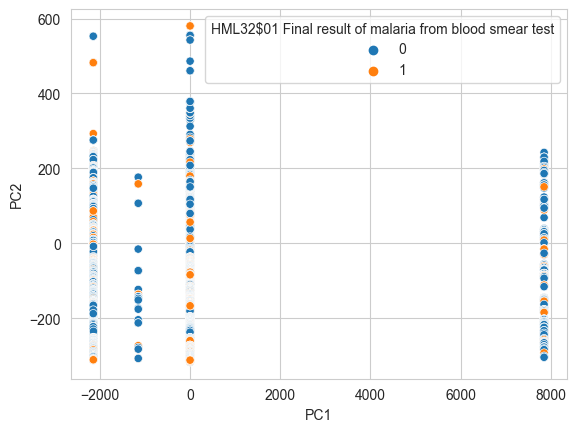

In [23]:

# Due to the large number of columns, exploratory data analysis is not easy. PCA is used to reduce the number of columns. inorder to perform EDA, the data is reduced to 2 dimensions using PCA.

# Split the data into features and labels
X = demo_socio_data.drop([target], axis=1)
y = demo_socio_data[target]

# Instantiate a PCA object and fit it to the data
pca = PCA(n_components=2)
pca.fit(X)

# Transform the data into 2D using the PCA object
X_2d = pca.transform(X)

# Plot the transformed data
# plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y)

sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=y)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [24]:
new_data = demo_socio_data.__deepcopy__()
Y_data = new_data.pop(target)
X_data = new_data

Class Labels Index([0, 1], dtype='int64', name='HML32$01 Final result of malaria from blood smear test')
Class Counts [8390 2265]
Class Percentage [78.74237447 21.25762553]


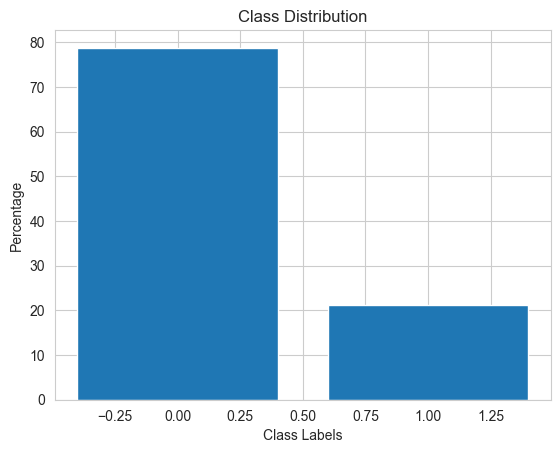

In [25]:
# Assuming your target variable is stored in a column called 'target'
target_counts = Y_data.value_counts()

# Calculate the class distribution
class_labels = target_counts.index
class_counts = target_counts.values
total_samples = len(new_data)

# Calculate the percentage of each class
class_percentages = (class_counts / total_samples) * 100
print('Class Labels', class_labels)
print('Class Counts', class_counts)
print('Class Percentage', class_percentages)

# Plotting the class distribution
plt.bar(class_labels, class_percentages)
plt.xlabel('Class Labels')
plt.ylabel('Percentage')
plt.title('Class Distribution')
plt.show()

In [26]:
def undersampling():
    # Perform undersampling
    undersampler = RandomUnderSampler(sampling_strategy='majority')
    return undersampler.fit_resample(X_data, Y_data)


def oversampling():
    # Perform oversampling
    oversampler = RandomOverSampler(sampling_strategy='minority')
    return oversampler.fit_resample(X_data, Y_data)


def smote():
    # Perform SMOTE
    smote_sampler = SMOTE(sampling_strategy='minority')
    return smote_sampler.fit_resample(X_data, Y_data)


classifier = LogisticRegression()
results = {}
for algorithm in [undersampling, oversampling, smote]:
    X, Y = algorithm()
    classifier.fit(X, Y)
    predicted_labels = classifier.predict(X_data)
    accuracy = accuracy_score(Y_data, predicted_labels)
    results[algorithm.__name__] = accuracy

# Determine the best algorithm based on the accuracy
best_algorithm = max(results, key=results.get)

# Print the results and the best algorithm
print("Sampling Algorithm Results:")
for algorithm, accuracy in results.items():
    print(f"{algorithm}: {accuracy}")
print("\nBest Algorithm:")
print(best_algorithm)

/Library/Python/3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Python/3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimiz

Sampling Algorithm Results:
undersampling: 0.5493195682778038
oversampling: 0.5572970436414829
smote: 0.5526044110746129

Best Algorithm:
oversampling


/Library/Python/3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
# Assume X_train and y_train are your training data
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]  # Example threshold values to test

best_threshold = None
best_score = 0

for threshold in thresholds:
    sel = VarianceThreshold(threshold=threshold)
    X_train_selected = sel.fit_transform(X_data)
    # Assume RandomForestClassifier as your model, modify it based on your problem
    clf = RandomForestClassifier()
    scores = cross_val_score(clf, X_train_selected, Y_data, cv=5, scoring='accuracy')
    avg_score = scores.mean()
    print(f"Threshold: {threshold}, Average Cross-Validation Score: {avg_score}")
    if avg_score > best_score:
        best_score = avg_score
        best_threshold = threshold

print(f"Best Threshold: {best_threshold}, Best Cross-Validation Score: {best_score}")


Threshold: 0, Average Cross-Validation Score: 0.6788362271234162
Threshold: 0.1, Average Cross-Validation Score: 0.664946034725481
Threshold: 0.2, Average Cross-Validation Score: 0.6711403097137494
Threshold: 0.3, Average Cross-Validation Score: 0.6621304551853591
Threshold: 0.4, Average Cross-Validation Score: 0.6595964335992492
Threshold: 0.5, Average Cross-Validation Score: 0.6551853589863914
Threshold: 0.6, Average Cross-Validation Score: 0.6639136555607695
Threshold: 0.7, Average Cross-Validation Score: 0.6458000938526514
Threshold: 0.8, Average Cross-Validation Score: 0.6491787893007978
Threshold: 0.9, Average Cross-Validation Score: 0.6550915063350541
Threshold: 1, Average Cross-Validation Score: 0.6423275457531675
Best Threshold: 0, Best Cross-Validation Score: 0.6788362271234162


In [28]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0.5)
sel.fit(X_data)
sum(sel.get_support())
print(
    len([
        x for x in X_data.columns
        if x not in X_data.columns[sel.get_support()]
    ]))

importance=[x for x in X_data.columns if x not in X_data.columns[sel.get_support()]]
importance   

13


['HV206    Has electricity',
 'HV207    Has radio',
 'HV208    Has television',
 'HV209    Has refrigerator',
 'HV210    Has bicycle',
 'HV211    Has motorcyclescooter',
 'HV212    Has cartruck',
 'HV219    Sex of head of household',
 'HV221    Has telephone (land-line)',
 'HV227    Has mosquito bed net for sleeping',
 'HV244    Owns land usable for agriculture',
 'HV246    Owns livestock, herds or farm animals',
 'HV247    Has bank account']

In [29]:
class func():
    def __init__(self, train, label, test, model, model_type, random_state):
        self.train, self.label, self.test = train, label, test
        self.model, self.model_type = model, model_type
        self.random_state = random_state

        assert self.model_type in ('catboost', 'xgboost', 'lgbm', 'log'), 'Incorrect model_type'

    def __call__(self, plot=True):
        return self.fit(plot)

    def fit(self, plot):
        def log_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train)
            x_test_predict = self.model.predict_proba(X_test)[:, 1]
            x_train_predict = self.model.predict_proba(X_train)[:, 1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:, 1]
            return x_test_predict, x_train_predict

        def catboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=500,
                           verbose=50, use_best_model=True)
            x_test_predict = self.model.predict_proba(X_test)[:, 1]
            x_train_predict = self.model.predict_proba(X_train)[:, 1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:, 1]
            return x_test_predict, x_train_predict

        def xgboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose=True)
            x_test_predict = self.model.predict_proba(X_test, ntree_limit=self.model.get_booster().best_ntree_limit)[:,
                             1]
            x_train_predict = self.model.predict_proba(X_train, ntree_limit=self.model.get_booster().best_ntree_limit)[
                              :, 1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, ntree_limit=self.model.get_booster().best_ntree_limit)[:,
                           1]
            return x_test_predict, x_train_predict

        def lgbm_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose=True)
            x_test_predict = self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)[:, 1]
            x_train_predict = self.model.predict_proba(X_train, num_iteration=self.model.best_iteration_)[:, 1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, num_iteration=self.model.best_iteration_)[:, 1]
            return x_test_predict, x_train_predict

        self.val_p = np.zeros(self.train.shape[0])
        mean_val = []
        mean_train = []
        self.test_p = np.zeros(self.test.shape[0])
        splits = 5
        kf = StratifiedKFold(n_splits=splits)
        for fold_count, (train_index, test_index) in enumerate(kf.split(self.train, self.label)):
            X_train, X_test = self.train.iloc[train_index], self.train.iloc[test_index]
            y_train, y_test = self.label.iloc[train_index], self.label.iloc[test_index]

            print(f"================================Fold{fold_count + 1}====================================")
            if self.model_type == 'catboost':
                x_test_predict, x_train_predict = catboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'xgboost':
                x_test_predict, x_train_predict = xgboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'log':
                x_test_predict, x_train_predict = log_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'lgbm':
                x_test_predict, x_train_predict = lgbm_fit(X_train, X_test, y_train, y_test)
            print('\nValidation scores', roc_auc_score(y_test, x_test_predict), log_loss(y_test, x_test_predict))
            print('Training scores', roc_auc_score(y_train, x_train_predict), log_loss(y_train, x_train_predict))
            mean_val.append(roc_auc_score(y_train, x_train_predict))
            mean_train.append(roc_auc_score(y_train, x_train_predict))

        if plot and self.model_type != 'log':
            feat_imp = pd.DataFrame(sorted(zip(self.model.feature_importances_, self.train.columns)),
                                    columns=['Value', 'Feature'])
            plt.figure(figsize=(30, 25))
            sns.barplot(x="Value", y="Feature", data=feat_imp.sort_values(by="Value", ascending=False))
            plt.ylabel('Feature Importance Score')
            plt.show()
        print(np.mean(mean_val), np.mean(mean_train), np.std(mean_val))
        return self.val_p, self.test_p / splits, self.model

In [30]:
def train_neural(X_train, y_train, X_test, y_test):
    from subprocess import check_output
    import pandas as pd
    import numpy as np
    import warnings
    warnings.filterwarnings('ignore')
    import matplotlib.pyplot as plt
    from sklearn.model_selection import train_test_split
    import keras
    import tensorflow as tf
    from keras.models import Sequential
    from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
    from keras.optimizers import Adam
    from keras.callbacks import TensorBoard
    num_classes = 10
    epochs = 20
    data_rows = X_train.shape[0]
    data_cols = X_train.shape[1]
    batch_size = 4096
    data_shape = (data_rows,data_cols,1)
    NN_model = Sequential()
    
    # The Input Layer :
    NN_model.add(Dense(324, kernel_initializer='normal', input_dim=X_train.shape[1], activation='relu'))
    
    # The Hidden Layers :
    NN_model.add(Dense(512, activation='relu'))
    NN_model.add(Dense(1024, activation='relu'))
    NN_model.add(Dense(1024, activation='relu'))
    NN_model.add(Dense(512, activation='relu'))
    NN_model.add(Dense(256, activation='relu'))
    
    NN_model.add(Flatten())
    
    NN_model.add(Dense(4096, activation='relu'))
    NN_model.add(Dropout(0.5))
    
    NN_model.add(Dense(4096, activation='relu'))
    NN_model.add(Dropout(0.5))
    
    # The Output Layer :
    NN_model.add(
        Dense(2, kernel_initializer='normal', activation='relu', kernel_regularizer=tf.keras.regularizers.l1(l=0.01)))
    # NN_model.add(Dense(1, kernel_initializer='normal',activation='linear', kernel_regularizer = tf.keras.regularizers.l1(l=0.01) ))
    
    optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)
    
    # Compile the network :
    NN_model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_absolute_error', 'accuracy'])
    # NN_model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_absolute_error'])
    NN_model.summary()
    NN_model.fit(X_train, y_train, epochs=3, batch_size=128, verbose=0)
    results = NN_model.evaluate(X_test, y_test)     
    nn_result = evaluate_model(y_test,np.argmax((NN_model.predict(X_test) > 0.5).astype("int32"), axis=-1))
    print("Neural Network", nn_result)
    return nn_result

In [31]:
 xgboost = xgb.XGBClassifier(objectsve='binary:logistic',
                            eta=0.99,
                            max_depth=6,
                            n_estimators=5000,
                            reg_lambda=500,
                            scoring='f1',
                            sub_sample=0.8,
                            colsample_bytree=0.8)
catboost = cat_.CatBoostClassifier(n_estimators=10000, max_depth=6, eval_metric='TotalF1', reg_lambda=370)
def run_predictions(X_train, y_train, X_test):
    # classifier with cross validation and feature selection
    func_ = func(X_train, y_train, X_test, classifier, 'log', 1000)
    val_p, test_p, model = func_()
    func_ = func(X_train, y_train, X_test, catboost, 'catboost', 1000)
    val_p1, test_p1, model1 = func_()
    func_ = func(X_train, y_train, X_test, xgboost, 'xgboost', 1000)
    val_p2, test_p2, model2 = func_()
    return model, model1, model2

In [32]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report,auc,roc_curve


def evaluate_model(y_true, y_pred, average='binary'):
    """
    Function to evaluate a machine learning model's performance using common evaluation metrics and the classification report.

    Parameters:
        y_true (array-like): The true labels of the data.
        y_pred (array-like): The predicted labels of the data.
        average (str, optional): The type of averaging to use for multi-class classification.
                                 Can be 'binary', 'micro', 'macro', or 'weighted'. Default is 'binary'.
                                 Ignored for binary classification problems.

    Returns:
        dict: A dictionary containing the evaluation metrics and the centered classification report.
    """

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)
    # Calculate classification report
    report = classification_report(y_true, y_pred)
    print('Classification Report')
    print(report)

    # Create dictionary of evaluation metrics and centered classification report
    metrics = {'accuracy': accuracy,
               'precision': precision,
               'recall': recall,
               'f1': f1}
    fpr, tpr, threshold = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    cm = confusion_matrix(y_true, y_pred)
    class_names = ['Class 0', 'Class 1']
    plt.figure()
    plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()
    print('Metrics for the  Evaluation is',metrics)
    return metrics


In [35]:
def eveluate_model_results(model1,model2, model, nn_result, y_test, X_test):
    catboost_result = evaluate_model(y_test, model1.predict(X_test))
    xgboost_result = evaluate_model(y_test, model2.predict(X_test))
    logistic_regression_result = evaluate_model(y_test, model.predict(X_test))
    print(
        {
          "catboost_result": catboost_result,
            "xgb":xgboost_result,
            "log":logistic_regression_result,
            "neural": nn_result
        }
    )
    accuracy_list = [catboost_result['accuracy'], xgboost_result['accuracy'], logistic_regression_result['accuracy'], nn_result['accuracy']]
    precision_list = [catboost_result['precision'], xgboost_result['precision'], logistic_regression_result['precision'], nn_result['precision']]
    recall_list = [catboost_result['recall'], xgboost_result['recall'], logistic_regression_result['recall'], nn_result['recall']]
    f1_list = [catboost_result['f1'], xgboost_result['f1'], logistic_regression_result['f1'], nn_result['f1']]
    
    # Calculate percentages for accuracy list
    total_accuracy = sum(accuracy_list)
    accuracy_percentages = [round((accuracy / total_accuracy) * 100, 2) for accuracy in accuracy_list]
    
    # Calculate percentages for precision list
    total_precision = sum(precision_list)
    precision_percentages = [round((precision / total_precision) * 100, 2) for precision in precision_list]
    
    # Calculate percentages for recall list
    total_recall = sum(recall_list)
    recall_percentages = [round((recall / total_recall) * 100, 2) for recall in recall_list]
    
    # Calculate percentages for f1 list
    total_f1 = sum(f1_list)
    f1_percentages = [round((f1 / total_f1) * 100, 2) for f1 in f1_list]
    
    # Set colors for the bars
    colors = ['#FFC107', '#FF5722', '#4CAF50']
    
    # Plot for accuracy list with percentages
    plt.figure(figsize=(12, 6))
    plt.bar(['Catboost', 'XGBoost', 'Logistic Regression','Neural Network'], accuracy_list, color=colors)
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Accuracy of different models')
    
    # Add percentage labels to the bars
    for i, accuracy in enumerate(accuracy_list):
        plt.text(i, accuracy + 0.5, f"{accuracy_percentages[i]}%", ha='center')
    
    plt.show()
    
    # Plot for precision list with percentages
    plt.figure(figsize=(12, 6))
    plt.bar(['Catboost', 'XGBoost', 'Logistic Regression','Neural Network'], precision_list, color=colors)
    plt.xlabel('Model')
    plt.ylabel('Precision')
    plt.title('Precision of different models')
    
    # Add percentage labels to the bars
    for i, precision in enumerate(precision_list):
        plt.text(i, precision + 0.01, f"{precision_percentages[i]}%", ha='center')
    
    plt.show()
    
    # Plot for recall list with percentages
    plt.figure(figsize=(12, 6))
    plt.bar(['Catboost', 'XGBoost', 'Logistic Regression','Neural Network'], recall_list, color=colors)
    plt.xlabel('Model')
    plt.ylabel('Recall')
    plt.title('Recall of different models')
    
    # Add percentage labels to the bars
    for i, recall in enumerate(recall_list):
        plt.text(i, recall + 0.01, f"{recall_percentages[i]}%", ha='center')
    
    plt.show()
    
    # Plot for f1 list with percentages
    plt.figure(figsize=(12, 6))
    plt.bar(['Catboost', 'XGBoost', 'Logistic Regression','Neural Network'], f1_list, color=colors)
    plt.xlabel('Model')
    plt.ylabel('F1 Score')
    plt.title('F1 Score of different models')
    
    # Add percentage labels to the bars
    for i, f1 in enumerate(f1_list):
        plt.text(i, f1 + 0.01, f"{f1_percentages[i]}%", ha='center')
    
    plt.show()

/Library/Python/3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0:	learn: 0.6981320	total: 68.3ms	remaining: 11m 22s
1:	learn: 0.6981320	total: 75.3ms	remaining: 6m 16s
2:	learn: 0.6981320	total: 78.6ms	remaining: 4m 21s
3:	learn: 0.6981320	total: 84.5ms	remaining: 3m 31s
4:	learn: 0.6981320	total: 88ms	remaining: 2m 55s
5:	learn: 0.6981320	total: 91.2ms	remaining: 2m 31s
6:	learn: 0.6981320	total: 94.4ms	remaining: 2m 14s
7:	learn: 0.6981320	total: 97.5ms	remaining: 2m 1s
8:	learn: 0.6981320	total: 103ms	remaining: 1m 54s
9:	learn: 0.6981320	total: 107ms	remaining: 1m 46s
10:	learn: 0.6981320	total: 110ms	remaining: 1m 39s
11:	learn: 0.6981320	total: 121ms	remaining: 1m 41s
12:	learn: 0.6981320	total: 126ms	remaining: 1m 36s
13:	learn: 0.6981320	total: 129ms	remaining: 1m 32s
14:	learn: 0.6981320	total: 132ms	remaining: 1m 28s
15:	learn: 0.6981320	total: 136ms	remaining: 1m 24s
16:	learn: 0.6981320	total: 139ms	remaining: 1m 21s
17:	learn: 0.6981320	total: 143ms	remaining: 1m 19s
18:	learn: 0.6981320	total: 146ms	remaining: 1m 16s
19:	learn: 0.698

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 324)               13932     
                                                                 
 dense_1 (Dense)             (None, 512)               166400    
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 dense_3 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 flatten (Flatten)           (None, 256)               0

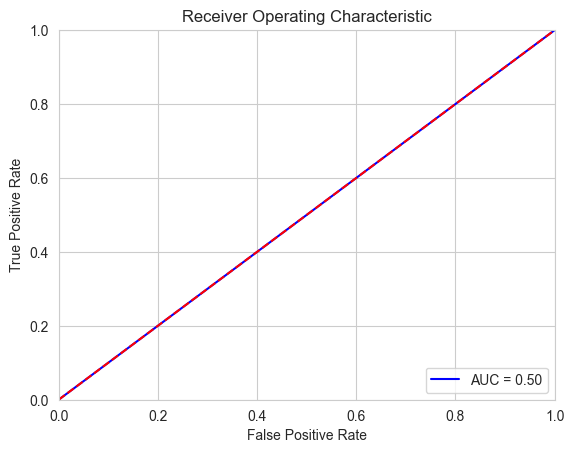

Normalized confusion matrix


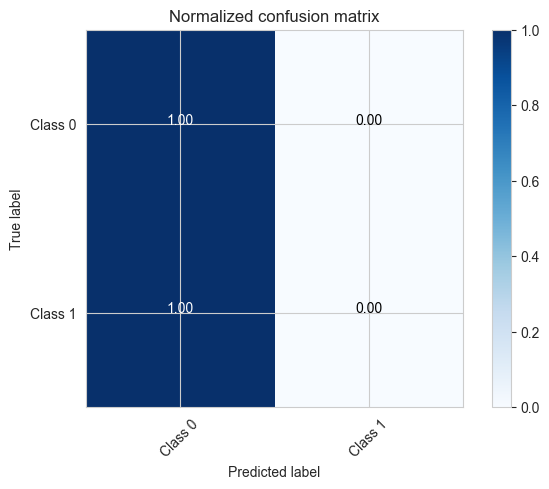

Metrics for the  Evaluation is {'accuracy': 0.7747536367902393, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Neural Network {'accuracy': 0.7747536367902393, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Classification Report
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      1651
           1       0.51      0.22      0.31       480

    accuracy                           0.78      2131
   macro avg       0.66      0.58      0.59      2131
weighted avg       0.74      0.78      0.74      2131


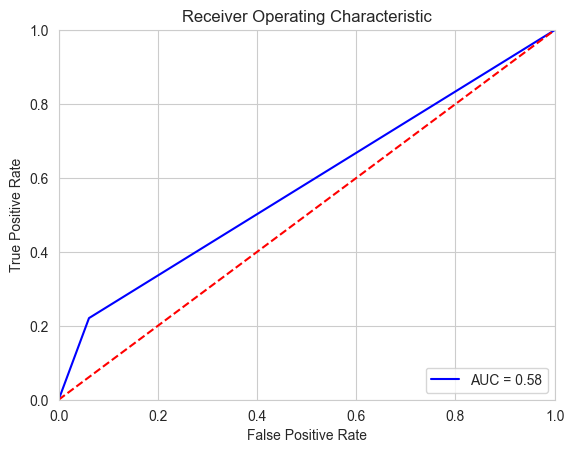

Normalized confusion matrix


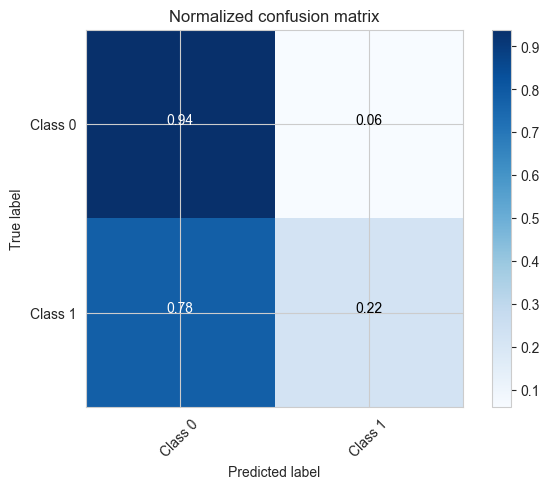

Metrics for the  Evaluation is {'accuracy': 0.7770999530736743, 'precision': 0.5120772946859904, 'recall': 0.22083333333333333, 'f1': 0.30858806404657935}
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1651
           1       0.44      0.31      0.36       480

    accuracy                           0.75      2131
   macro avg       0.63      0.60      0.61      2131
weighted avg       0.73      0.75      0.74      2131


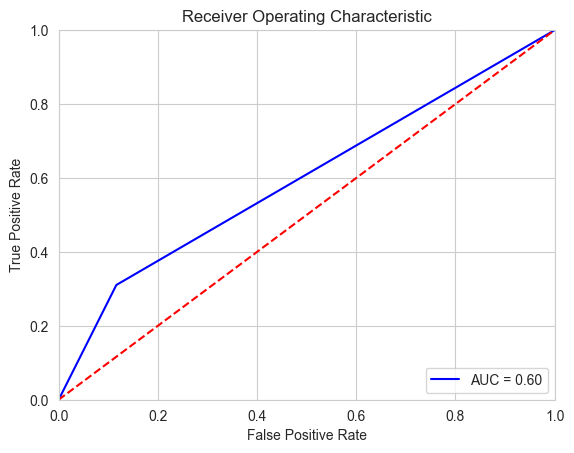

Normalized confusion matrix


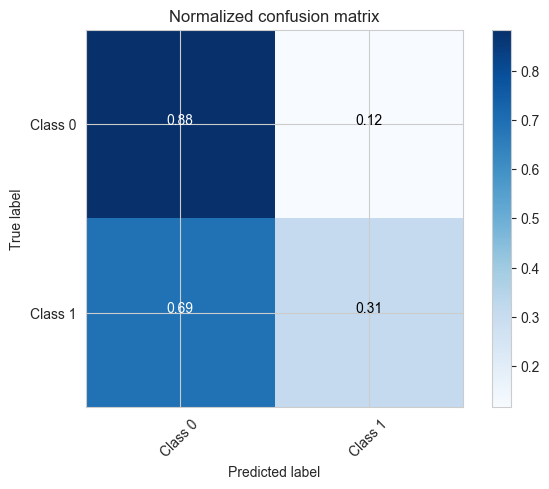

Metrics for the  Evaluation is {'accuracy': 0.7545753167526983, 'precision': 0.436950146627566, 'recall': 0.3104166666666667, 'f1': 0.3629719853836785}
Classification Report
              precision    recall  f1-score   support

           0       0.78      0.99      0.87      1651
           1       0.33      0.02      0.04       480

    accuracy                           0.77      2131
   macro avg       0.55      0.50      0.45      2131
weighted avg       0.68      0.77      0.68      2131


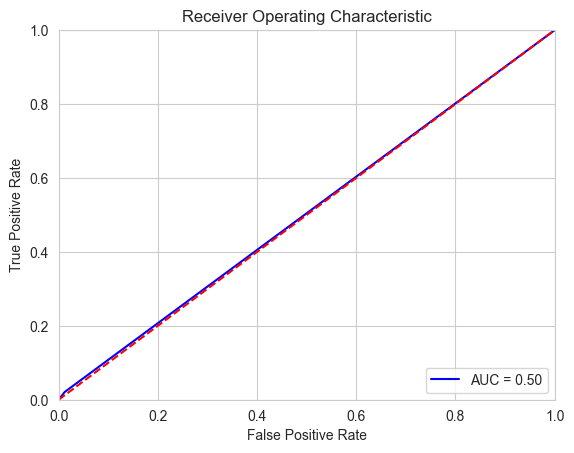

Normalized confusion matrix


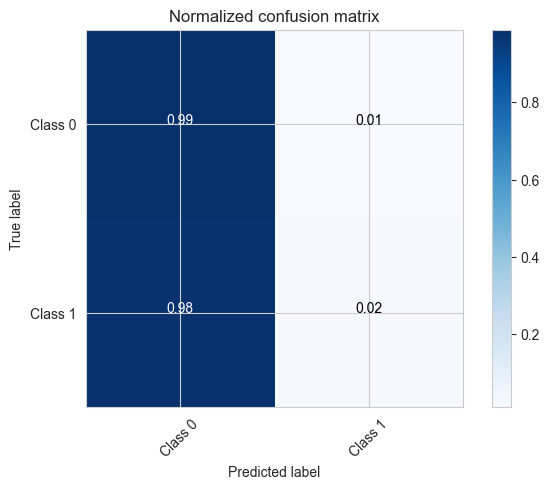

Metrics for the  Evaluation is {'accuracy': 0.7700610042233693, 'precision': 0.3333333333333333, 'recall': 0.020833333333333332, 'f1': 0.0392156862745098}
{'catboost_result': {'accuracy': 0.7770999530736743, 'precision': 0.5120772946859904, 'recall': 0.22083333333333333, 'f1': 0.30858806404657935}, 'xgb': {'accuracy': 0.7545753167526983, 'precision': 0.436950146627566, 'recall': 0.3104166666666667, 'f1': 0.3629719853836785}, 'log': {'accuracy': 0.7700610042233693, 'precision': 0.3333333333333333, 'recall': 0.020833333333333332, 'f1': 0.0392156862745098}, 'neural': {'accuracy': 0.7747536367902393, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}}


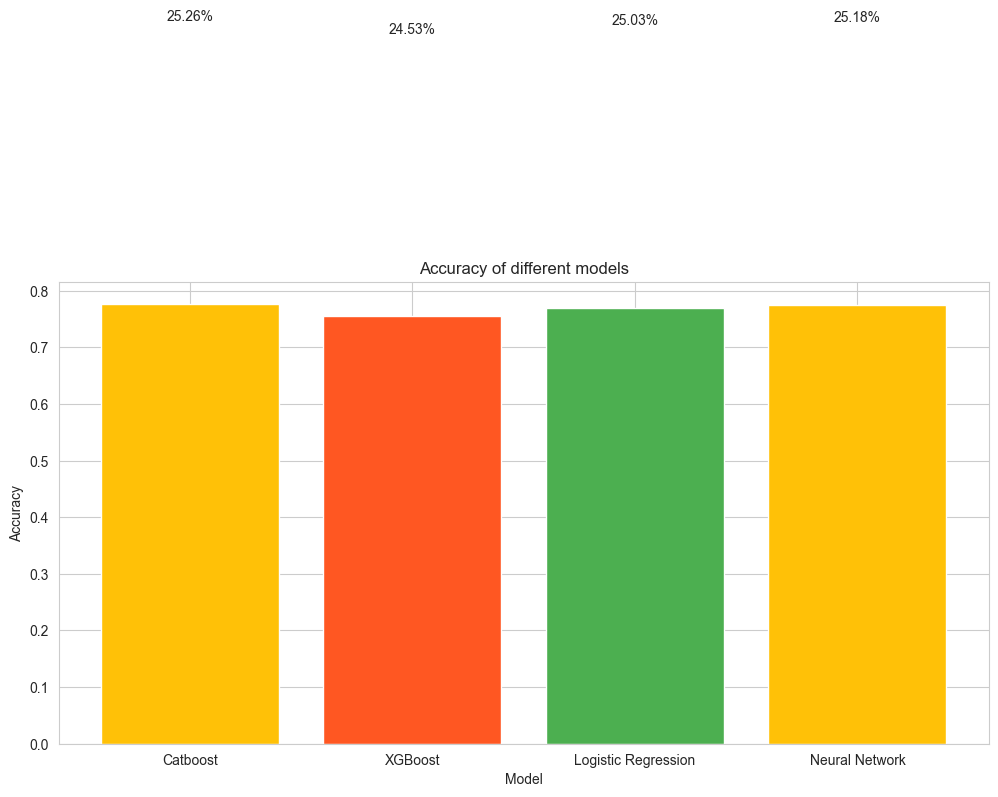

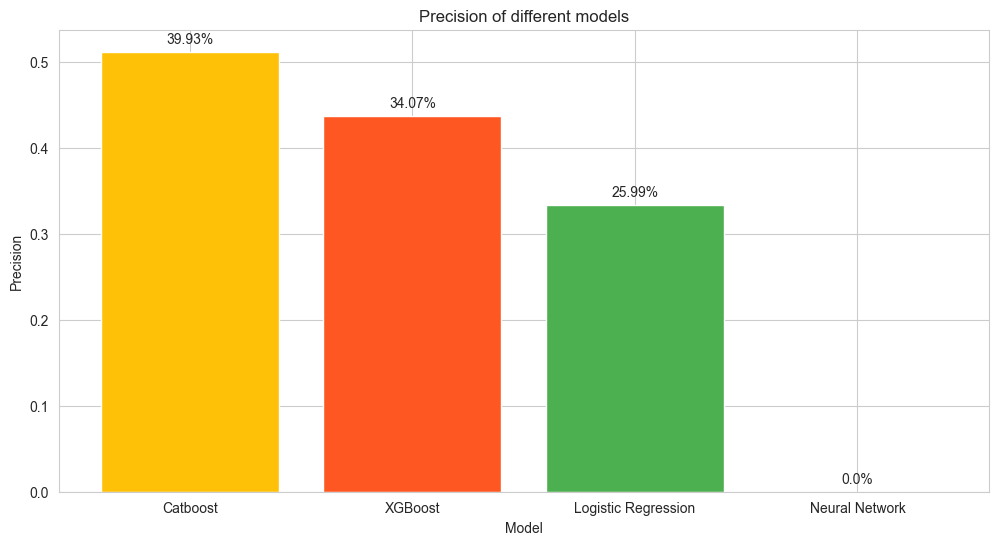

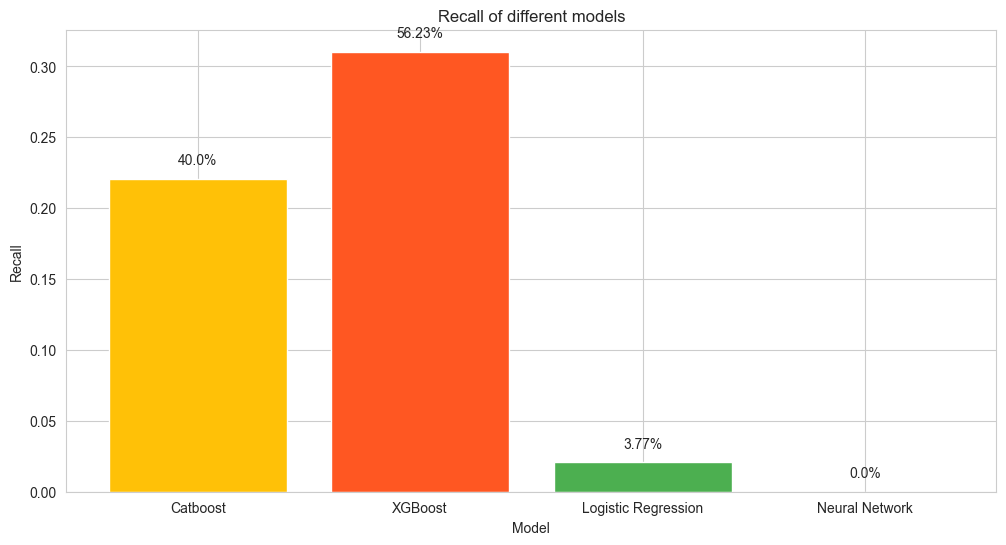

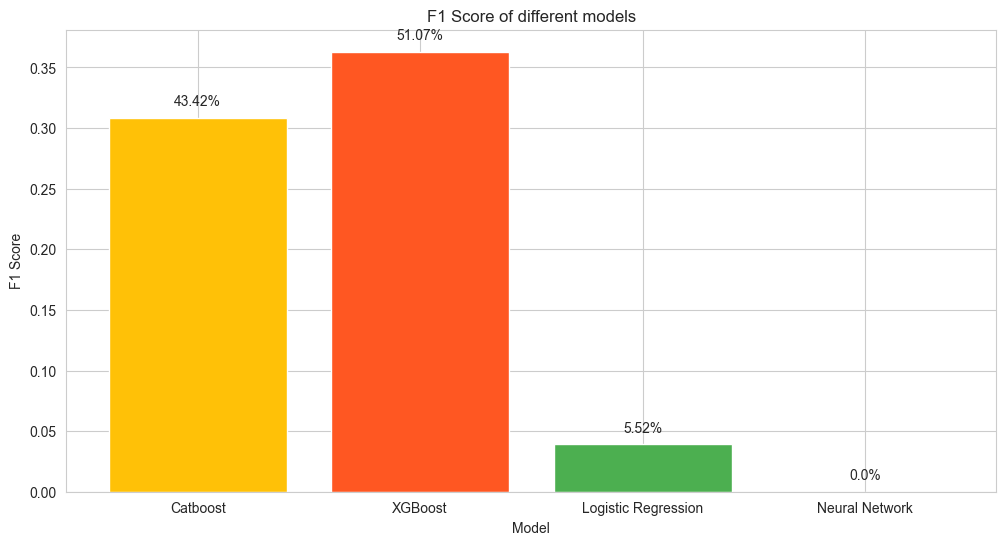

In [36]:
# Results without cross validation
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)
with_out_cross_classifier = classifier.fit(X_train, y_train)
with_out_cross_catboost = catboost.fit(X_train, y_train)
with_out_cross_xgboost = xgboost.fit(X_train, y_train)
with_out_cross_neural_result = train_neural(X_train,y_train,X_test, y_test)
eveluate_model_results(with_out_cross_catboost,with_out_cross_xgboost, with_out_cross_classifier, with_out_cross_neural_result, y_test, X_test)

================================Fold1====================================

Validation scores 0.6124604144328355 0.5056943707010187
Training scores 0.6233282127542169 0.5010402936429638
================================Fold2====================================

Validation scores 0.6351145799566117 0.5439152476820929
Training scores 0.6506463464629035 0.5018683036082505
================================Fold3====================================

Validation scores 0.616788852039332 0.5054344312730574
Training scores 0.6107855867258793 0.5096504541942728
================================Fold4====================================

Validation scores 0.6566913115394527 0.4982914694734393
Training scores 0.6538483970846732 0.4972055607395537
================================Fold5====================================

Validation scores 0.639158707283953 0.5035231179179134
Training scores 0.6722532577571088 0.49223524119736
0.6421723601569564 0.6421723601569564 0.022150531011384703
====================

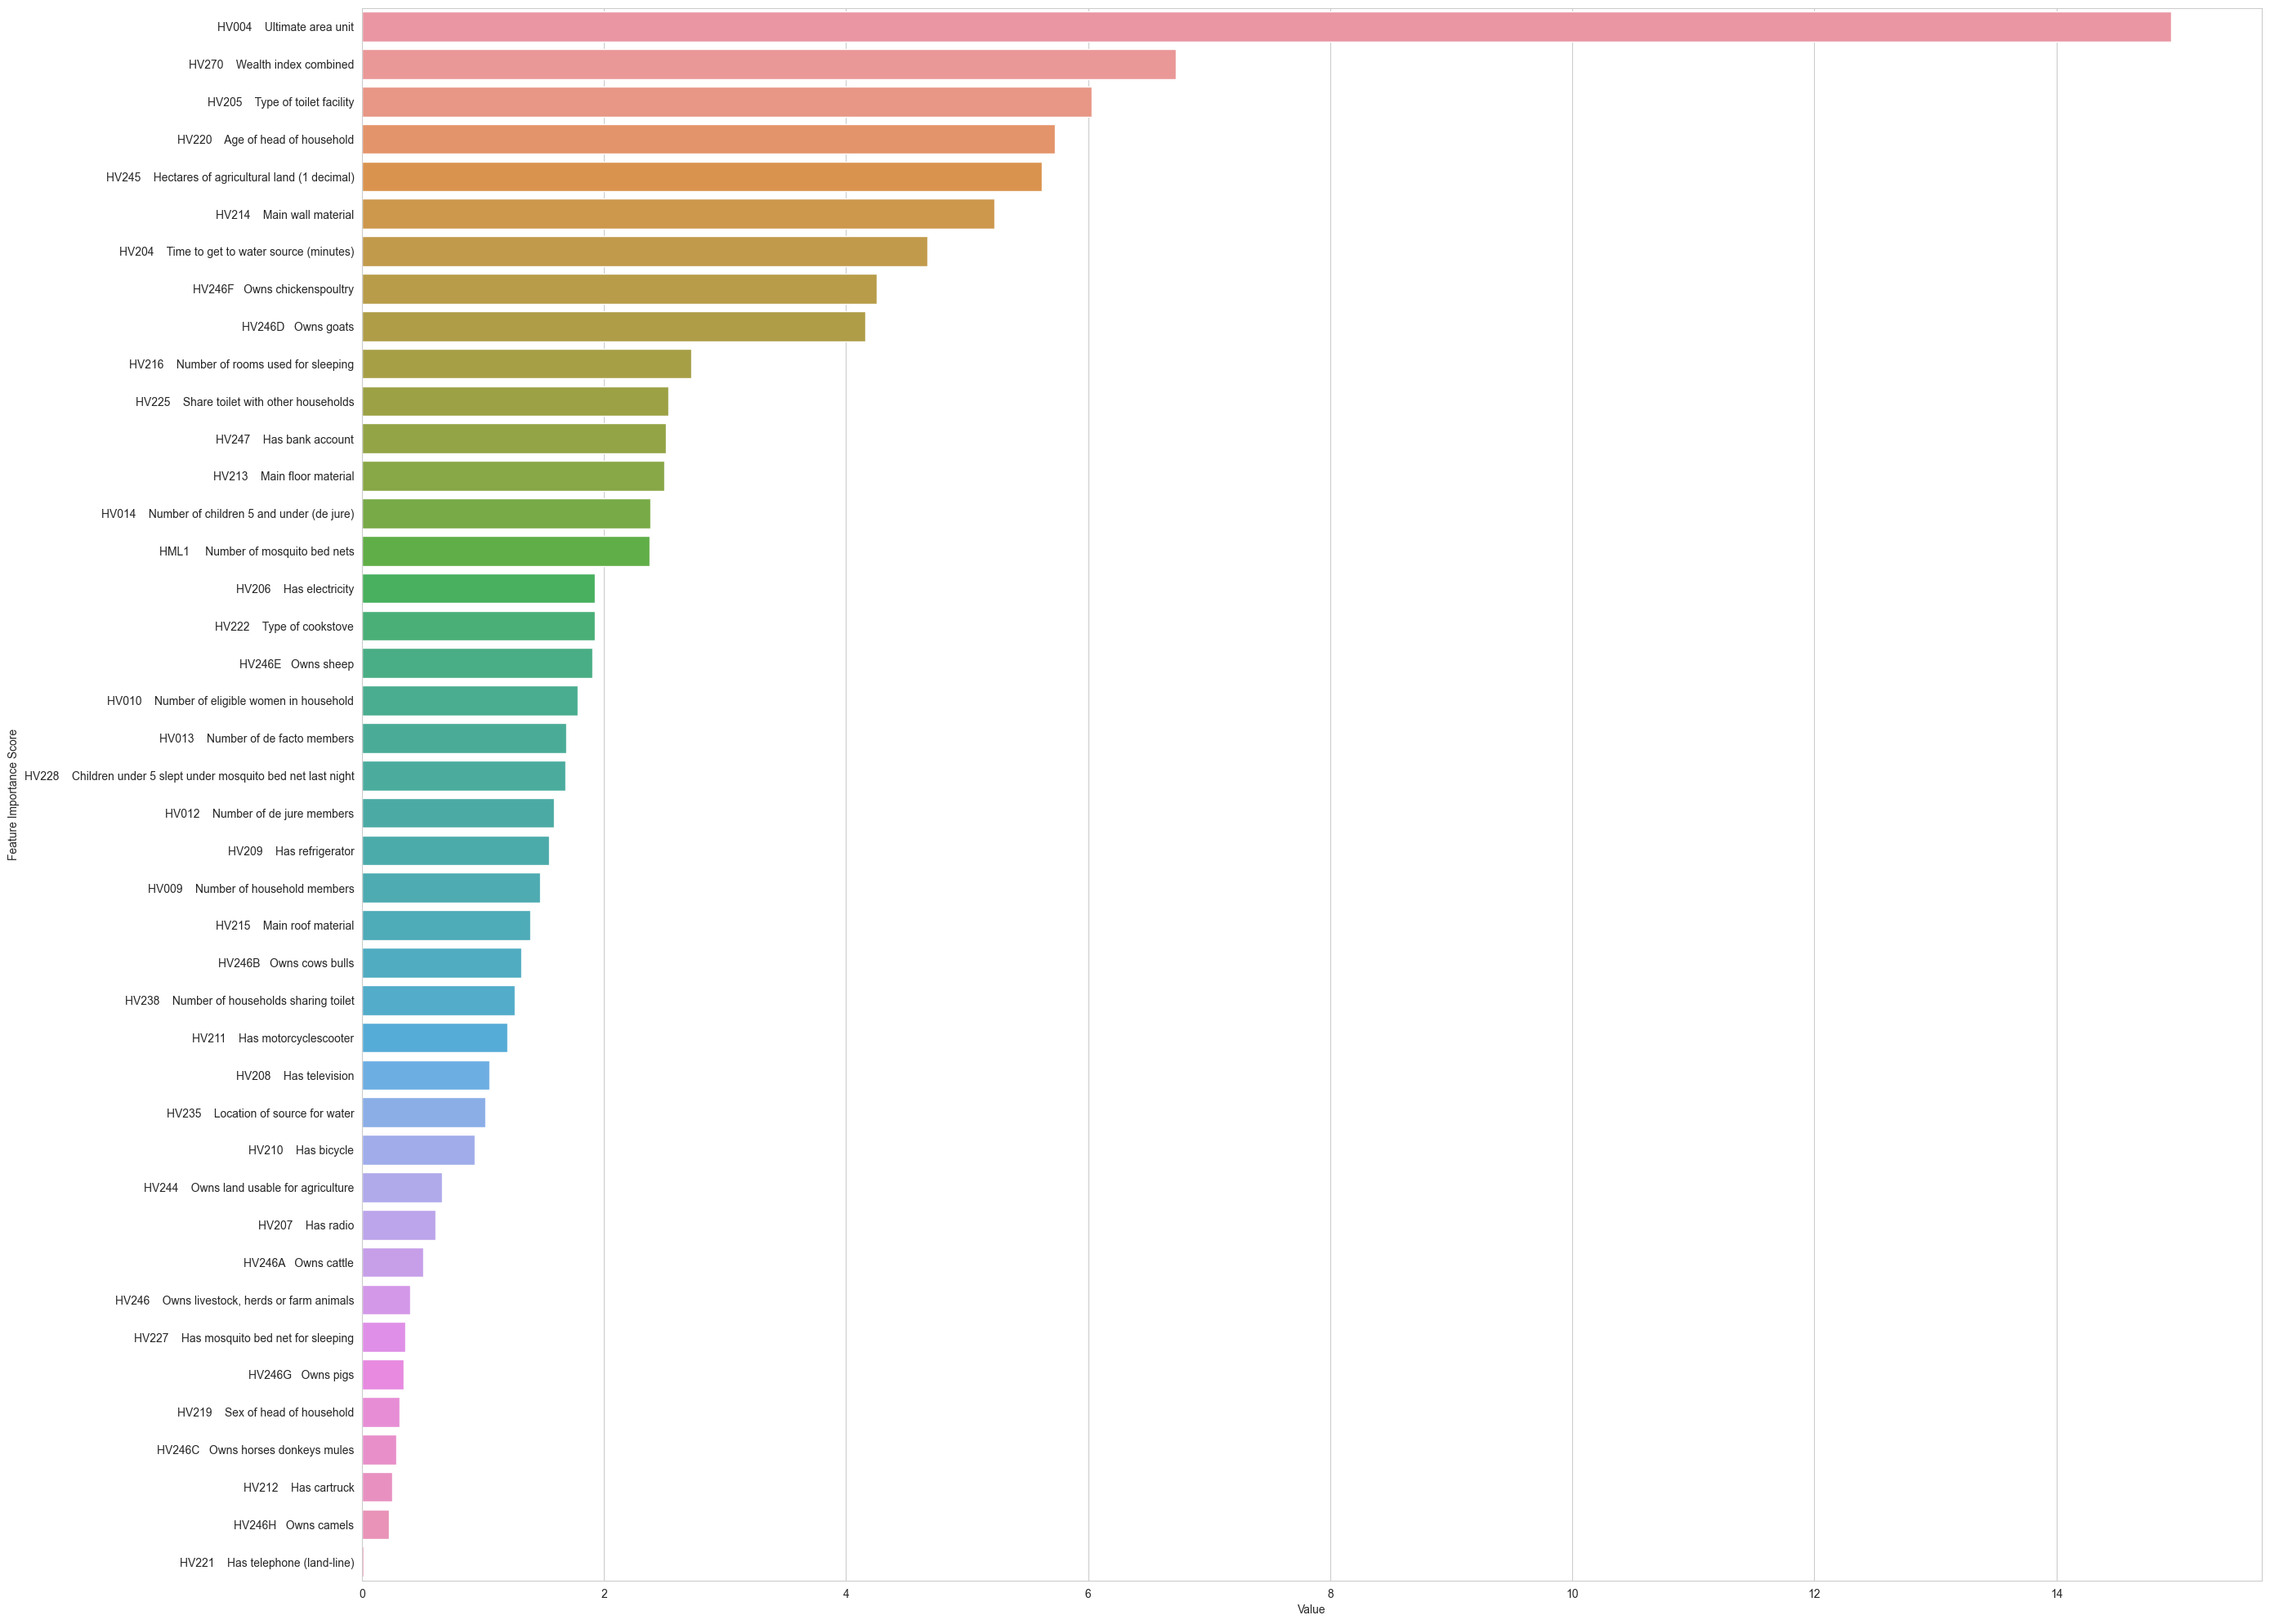

0.8792501502194231 0.8792501502194231 0.032012791898511896
================================Fold1====================================
[19:19:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "objectsve", "scoring", "sub_sample" } are not used.

[0]	validation_0-auc:0.50051
[1]	validation_0-auc:0.62325
[2]	validation_0-auc:0.67687
[3]	validation_0-auc:0.69442
[4]	validation_0-auc:0.69951
[5]	validation_0-auc:0.70717
[6]	validation_0-auc:0.70906
[7]	validation_0-auc:0.71181
[8]	validation_0-auc:0.71214
[9]	validation_0-auc:0.71231
[10]	validation_0-auc:0.71338
[11]	validation_0-auc:0.71364
[12]	validation_0-auc:0.71294
[13]	validation_0-auc:0.71054
[14]	validation_0-auc:0.71090
[15]	validation_0-auc:0.70919
[16]	validation_0-auc:0.71164
[17]	validation_0-auc:0.71027
[18]	validation_0-auc:0.71092
[19]	validation_0-auc:0.71097
[20]	validation_0-auc:0.71153
[21]	validation_0-auc:0.71145
[22]	valid

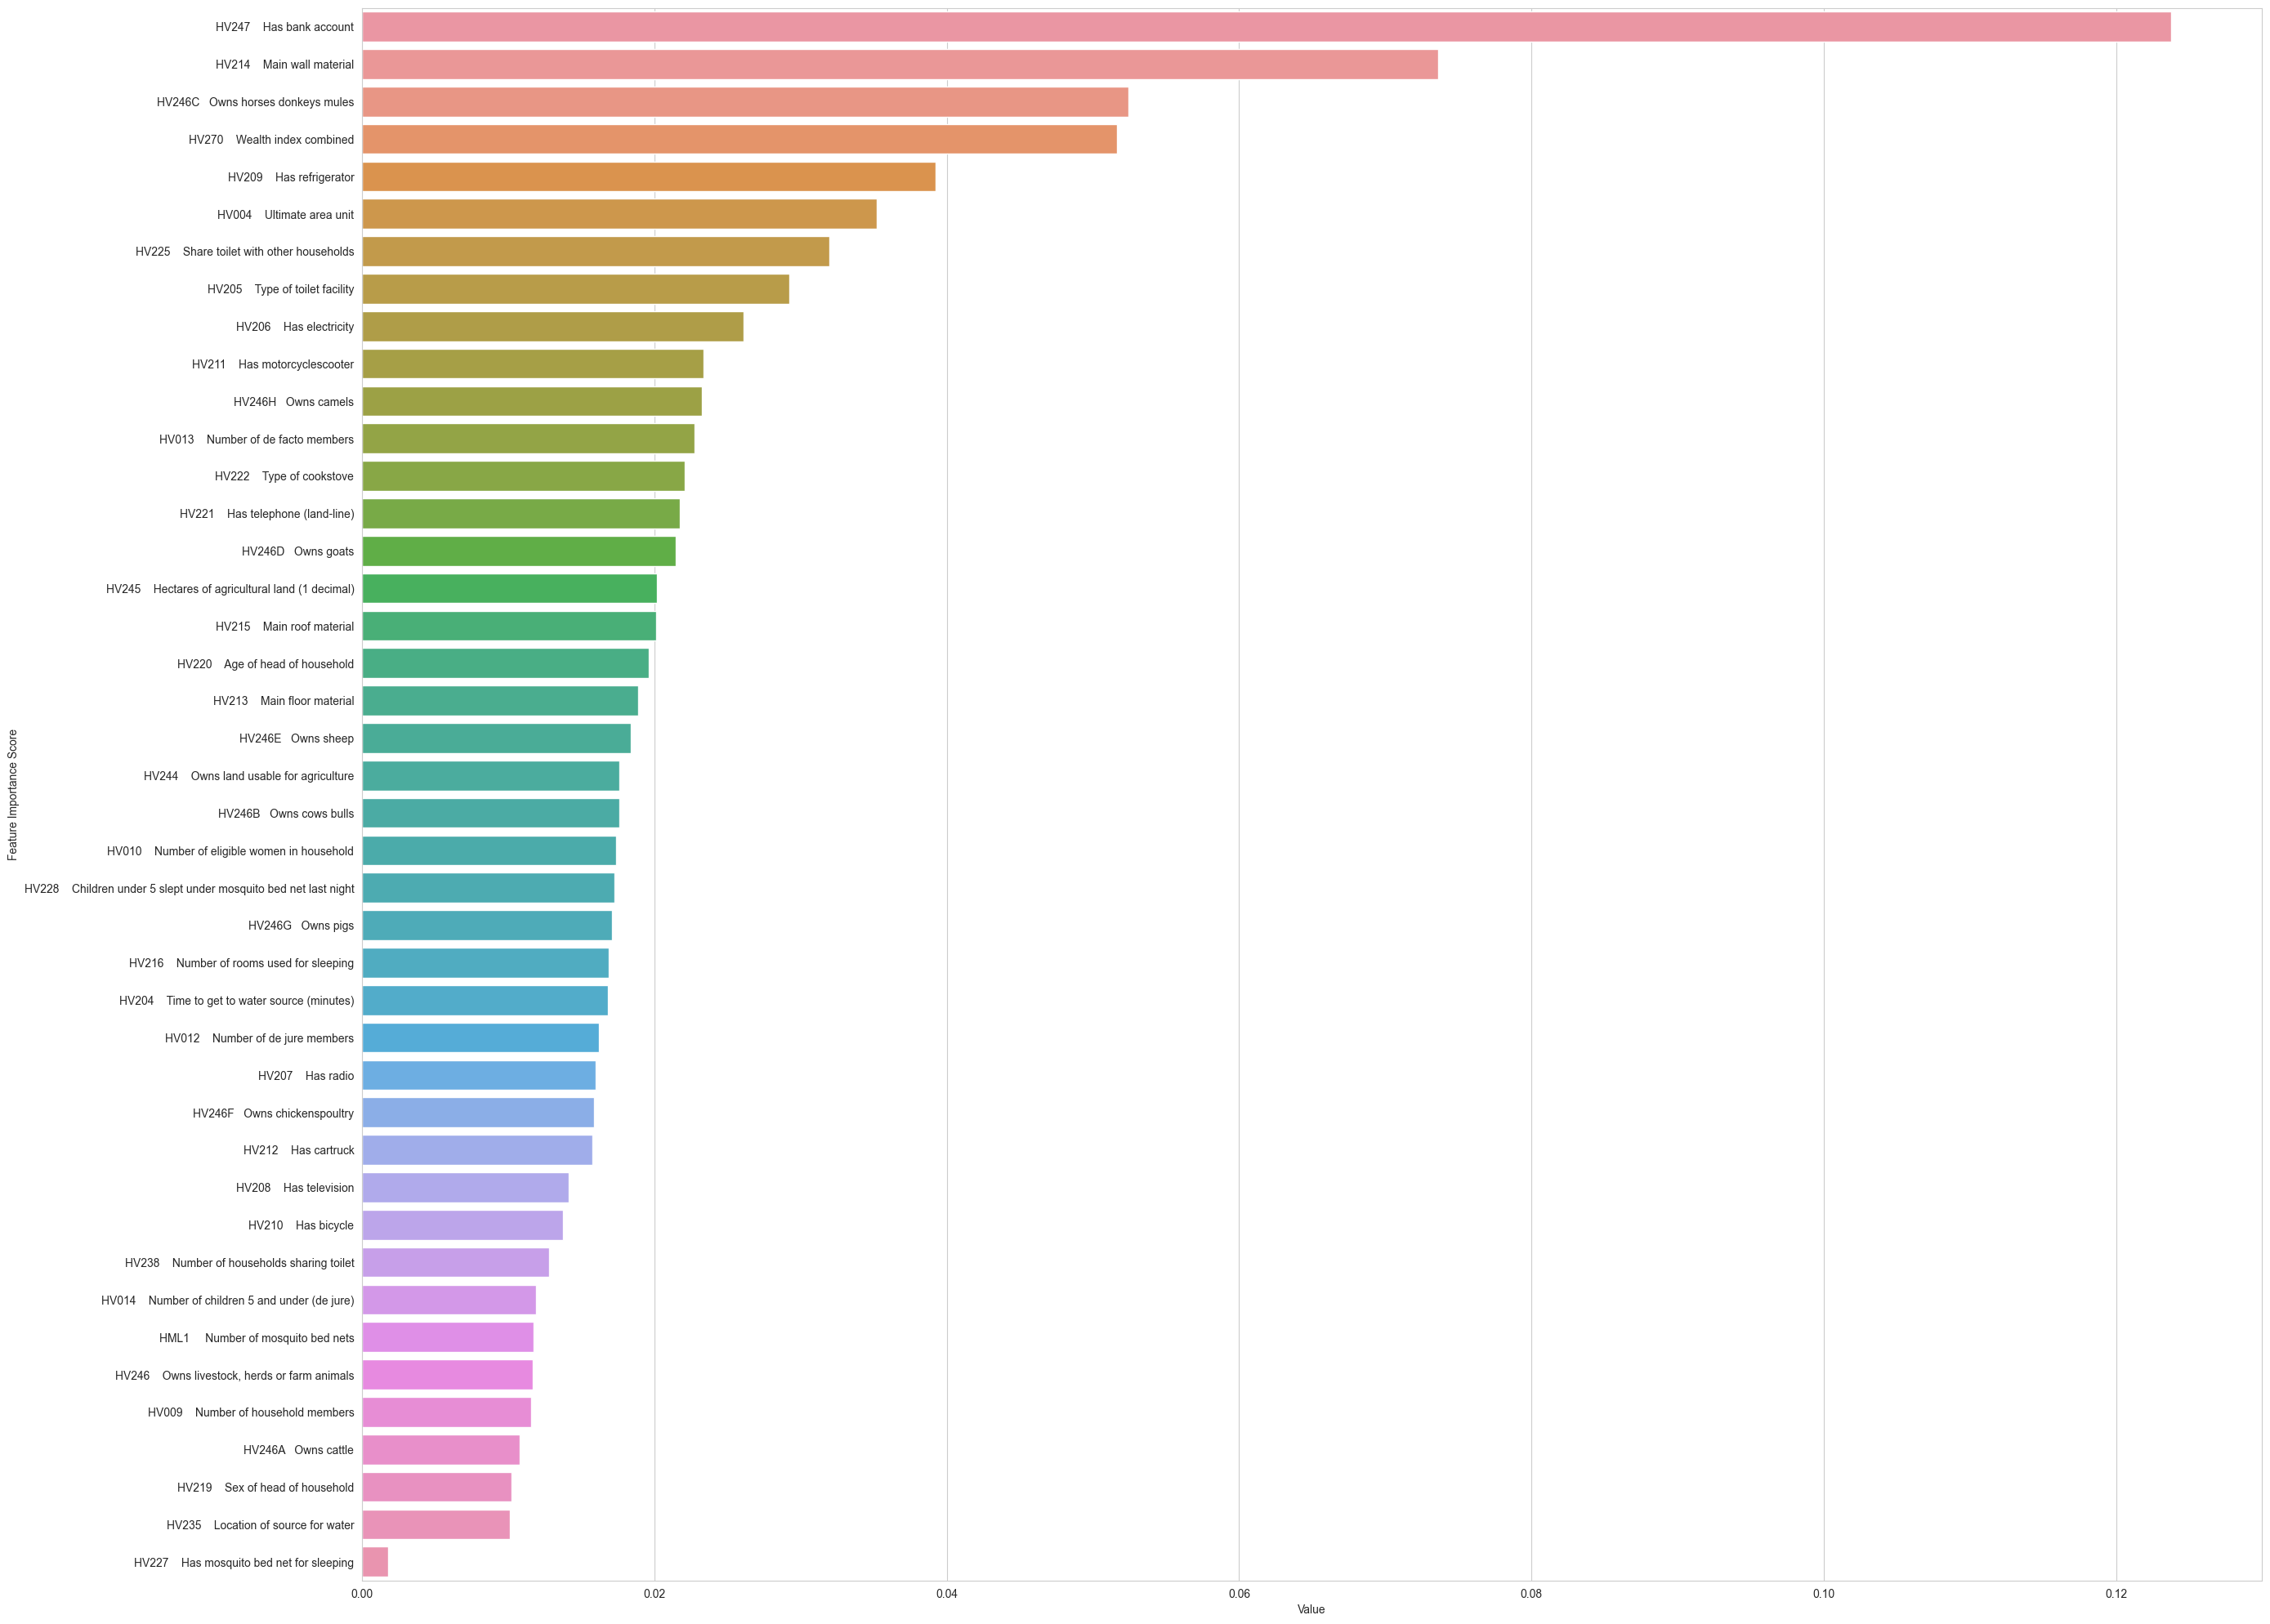

0.8772551208856487 0.8772551208856487 0.02032828325752382
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 324)               13932     
                                                                 
 dense_10 (Dense)            (None, 512)               166400    
                                                                 
 dense_11 (Dense)            (None, 1024)              525312    
                                                                 
 dense_12 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_13 (Dense)            (None, 512)               524800    
                                                                 
 dense_14 (Dense)            (None, 256)               131328    
                                                              

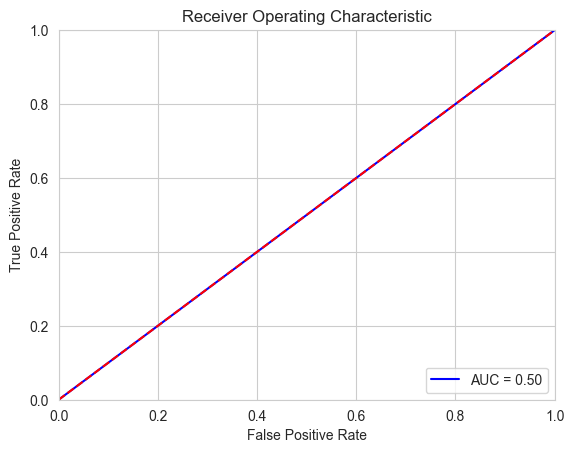

Normalized confusion matrix


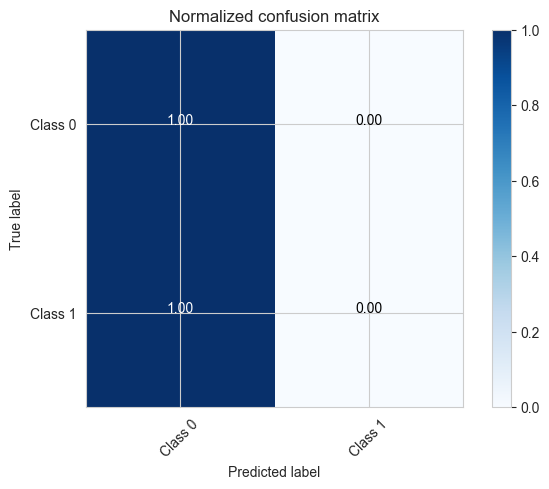

Metrics for the  Evaluation is {'accuracy': 0.7747536367902393, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Neural Network {'accuracy': 0.7747536367902393, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Classification Report
              precision    recall  f1-score   support

           0       0.79      0.97      0.87      1651
           1       0.54      0.14      0.22       480

    accuracy                           0.78      2131
   macro avg       0.67      0.55      0.55      2131
weighted avg       0.74      0.78      0.72      2131


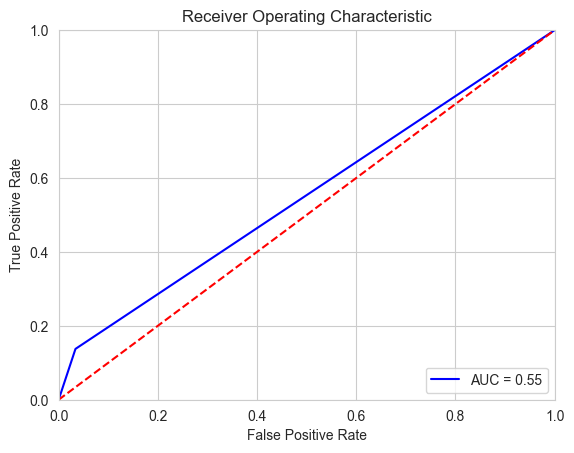

Normalized confusion matrix


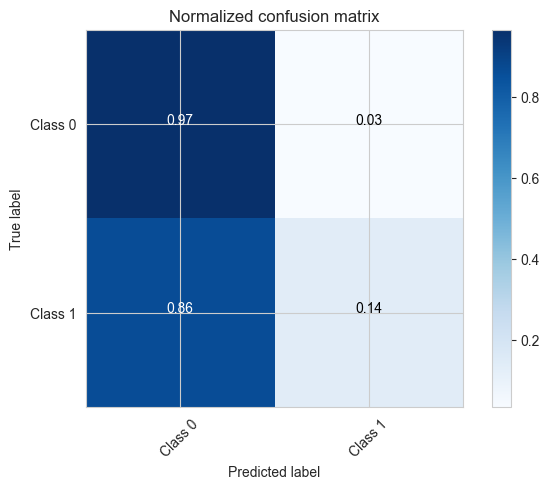

Metrics for the  Evaluation is {'accuracy': 0.7794462693571094, 'precision': 0.5409836065573771, 'recall': 0.1375, 'f1': 0.21926910299003324}
Classification Report
              precision    recall  f1-score   support

           0       0.79      0.97      0.87      1651
           1       0.59      0.13      0.21       480

    accuracy                           0.78      2131
   macro avg       0.69      0.55      0.54      2131
weighted avg       0.75      0.78      0.72      2131


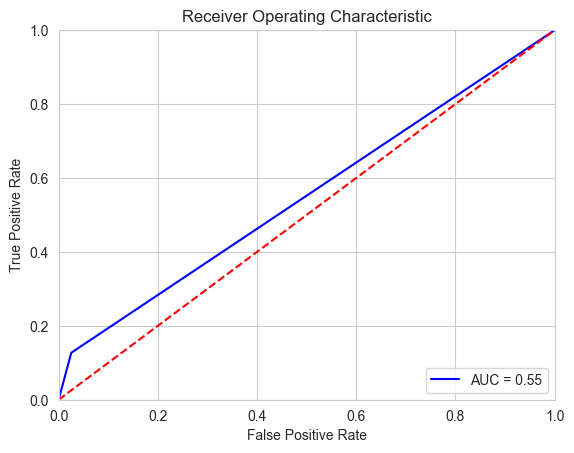

Normalized confusion matrix


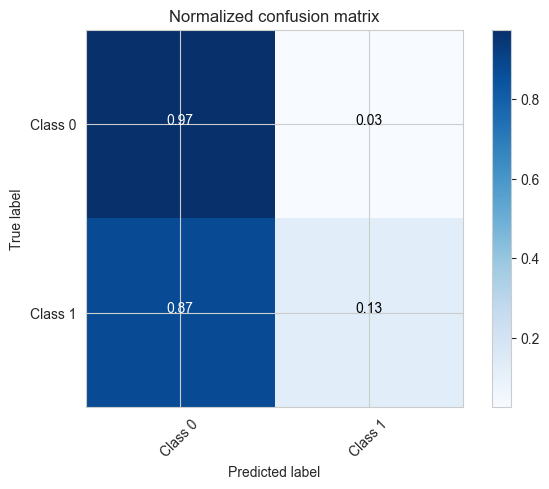

Metrics for the  Evaluation is {'accuracy': 0.7836696386672923, 'precision': 0.5922330097087378, 'recall': 0.12708333333333333, 'f1': 0.20926243567753}
Classification Report
              precision    recall  f1-score   support

           0       0.78      0.97      0.86      1651
           1       0.26      0.03      0.06       480

    accuracy                           0.76      2131
   macro avg       0.52      0.50      0.46      2131
weighted avg       0.66      0.76      0.68      2131


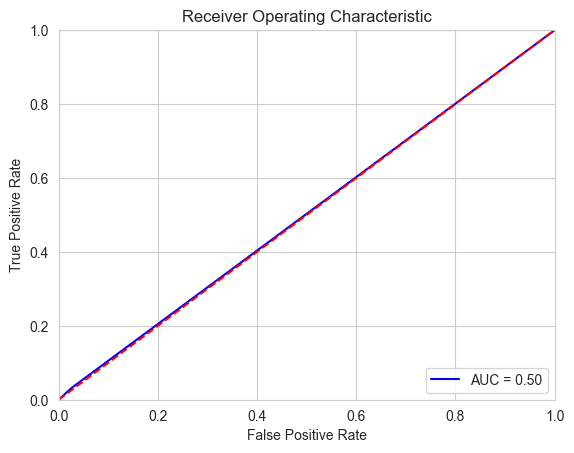

Normalized confusion matrix


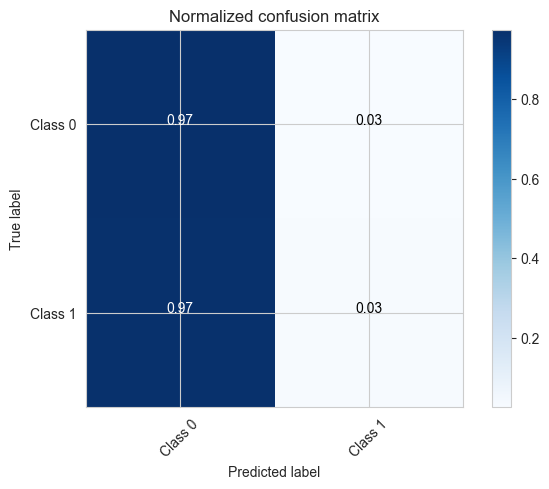

Metrics for the  Evaluation is {'accuracy': 0.7620835288596903, 'precision': 0.2631578947368421, 'recall': 0.03125, 'f1': 0.055865921787709494}
{'catboost_result': {'accuracy': 0.7794462693571094, 'precision': 0.5409836065573771, 'recall': 0.1375, 'f1': 0.21926910299003324}, 'xgb': {'accuracy': 0.7836696386672923, 'precision': 0.5922330097087378, 'recall': 0.12708333333333333, 'f1': 0.20926243567753}, 'log': {'accuracy': 0.7620835288596903, 'precision': 0.2631578947368421, 'recall': 0.03125, 'f1': 0.055865921787709494}, 'neural': {'accuracy': 0.7747536367902393, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}}


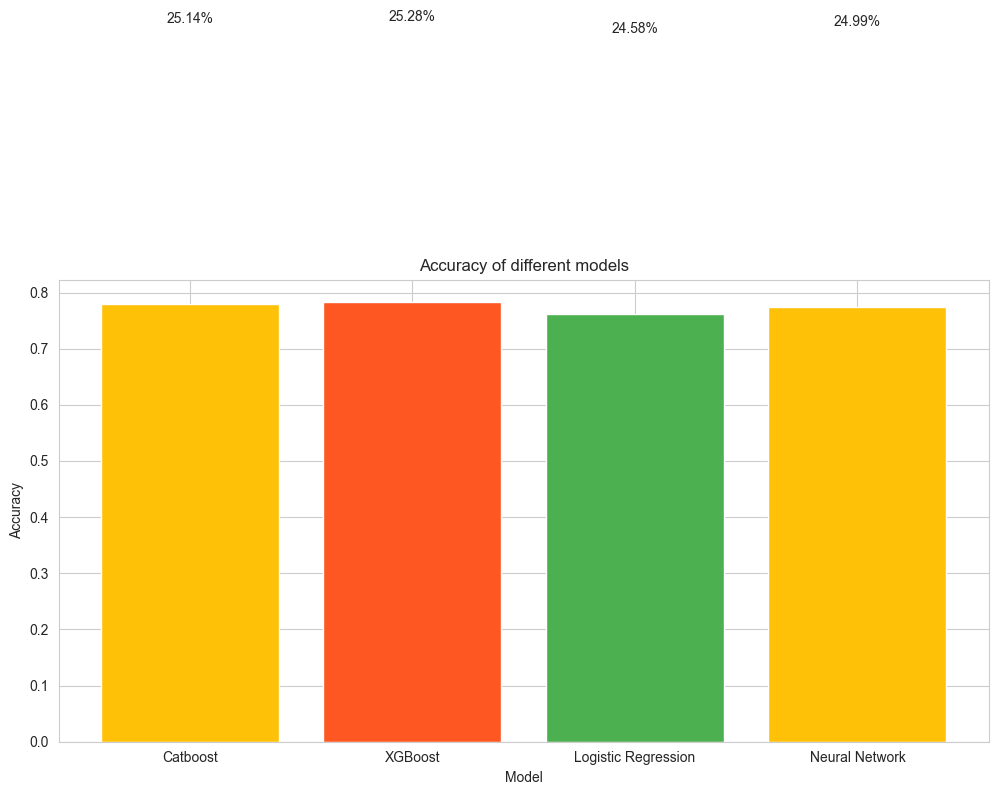

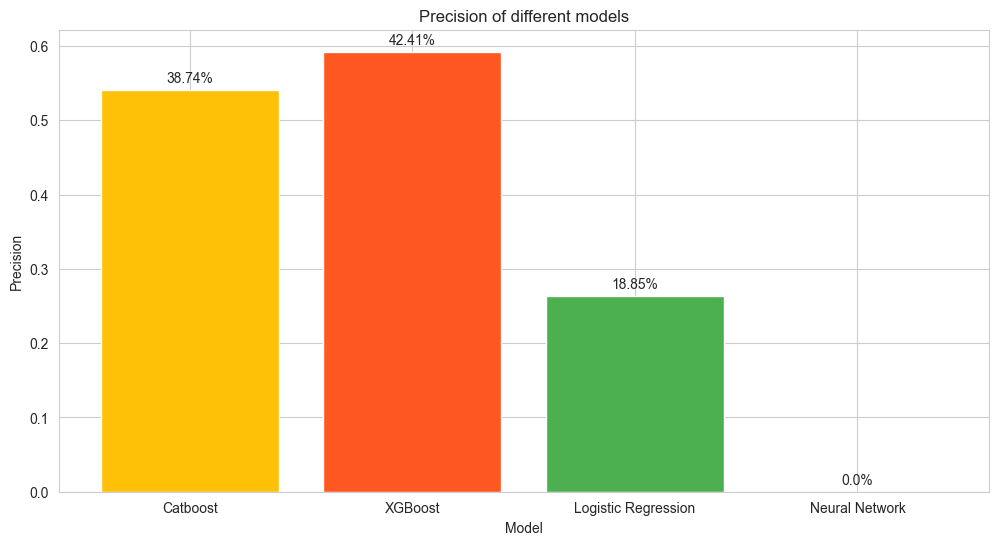

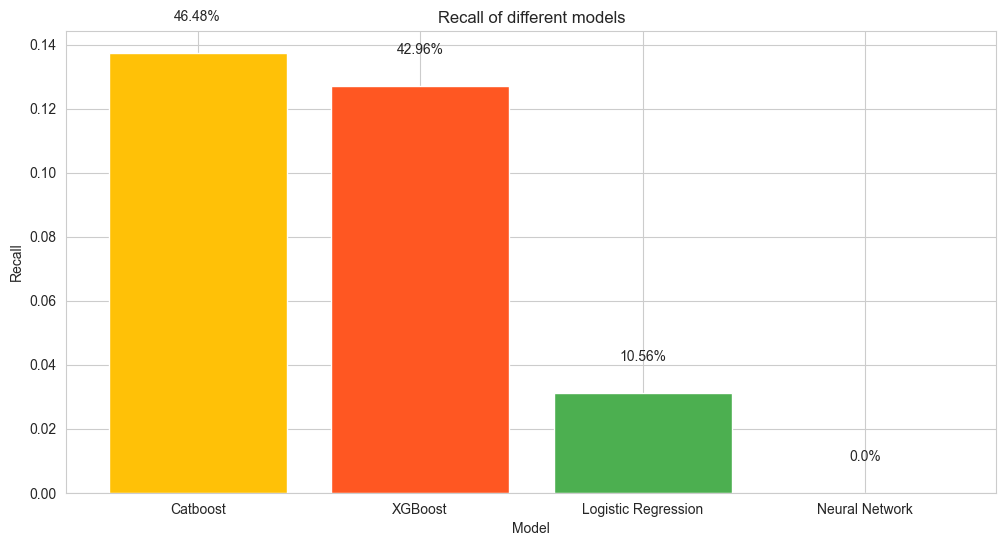

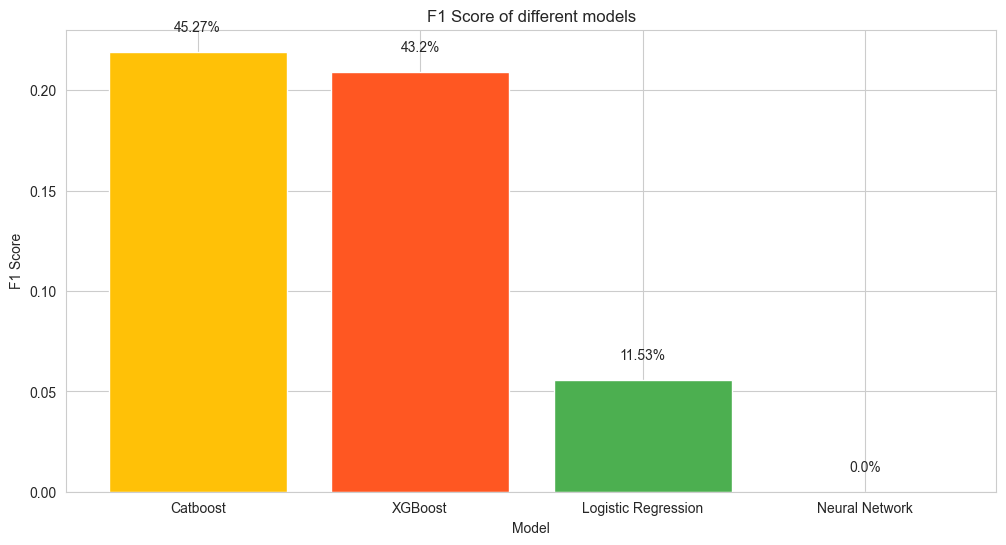

In [37]:
# Results with cross validation
with_cross_classifier,with_cross_catboost,with_cross_xgboost, = run_predictions(X_train,y_train, X_test)
with_cross_neural_result = train_neural(X_train,y_train,X_test, y_test)
eveluate_model_results(with_cross_catboost,with_cross_xgboost, with_cross_classifier, with_cross_neural_result, y_test, X_test)

================================Fold1====================================

Validation scores 0.6368174866385723 0.49052375319864233
Training scores 0.6663377649334636 0.4804146047396815
================================Fold2====================================

Validation scores 0.6426192138576499 0.4877672843305836
Training scores 0.6658141460999165 0.48099609164165835
================================Fold3====================================

Validation scores 0.6718595450049456 0.47907107982598446
Training scores 0.6594359595071566 0.4830621075306195
================================Fold4====================================

Validation scores 0.6724330681827627 0.47857953731604125
Training scores 0.6586572859527784 0.48340111287032594
================================Fold5====================================

Validation scores 0.6604156139070327 0.4843340458064942
Training scores 0.6624484920080792 0.4818149270051774
0.6625387297002788 0.6625387297002788 0.0031579091998164385
==========

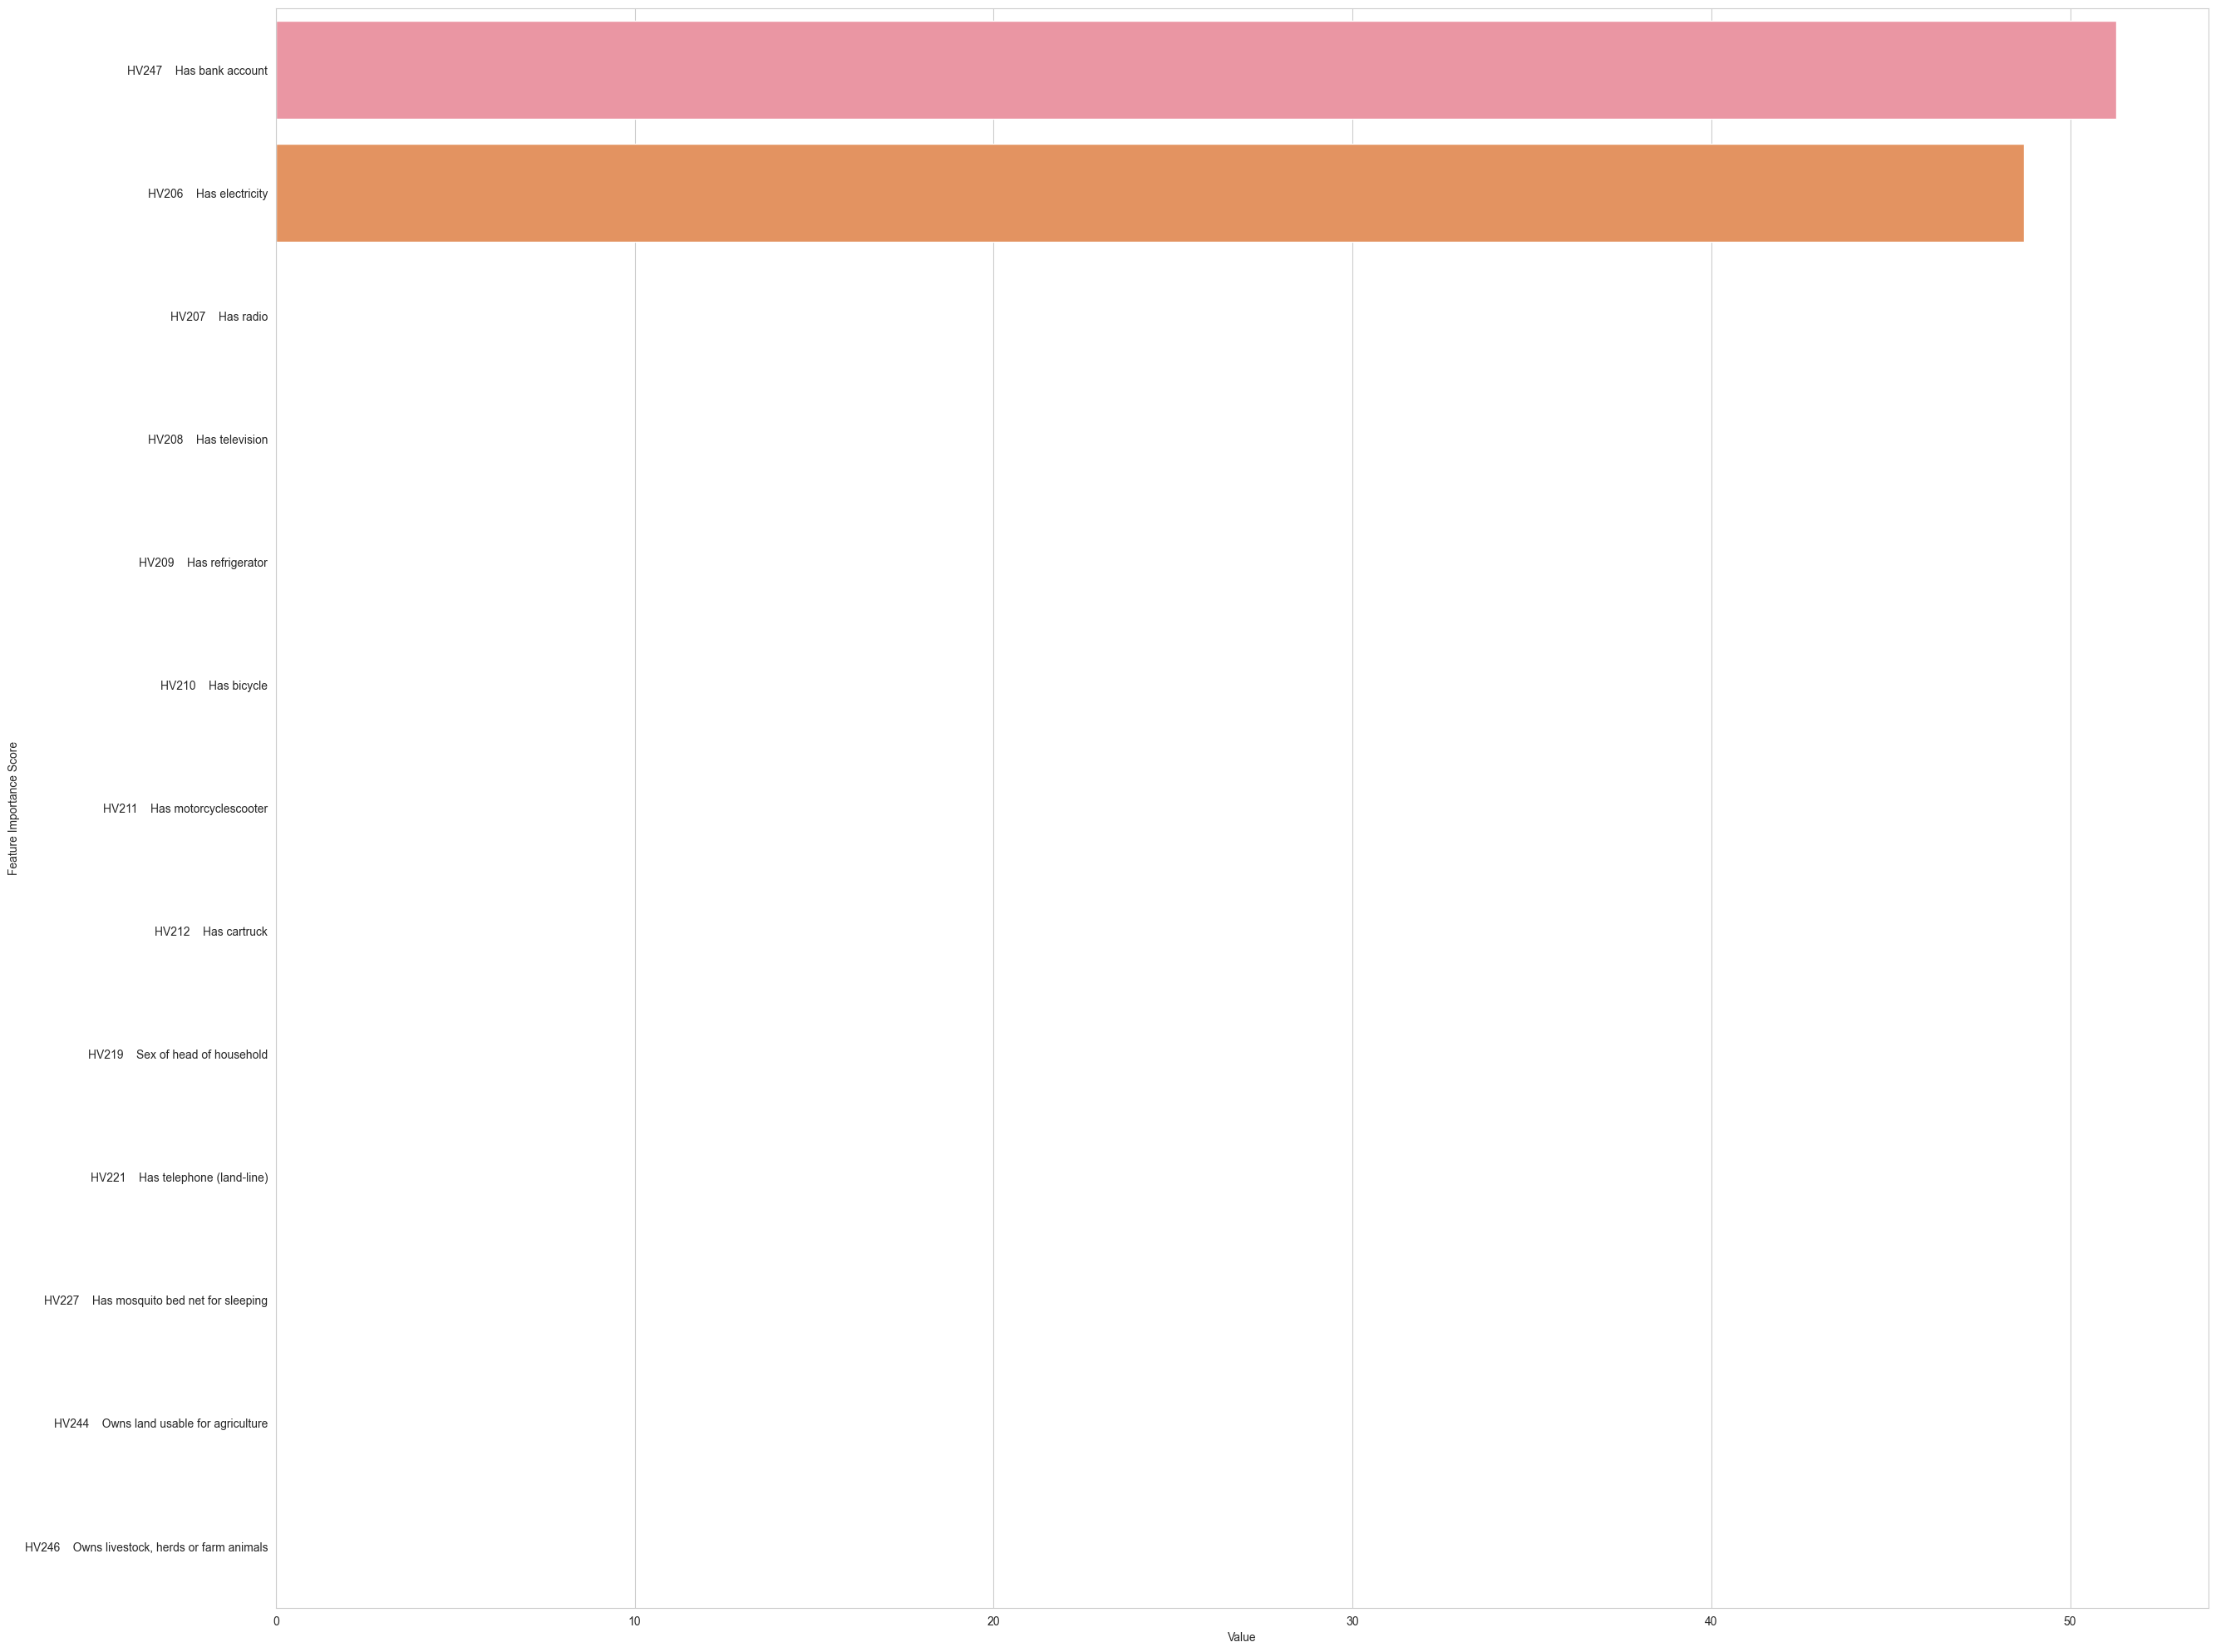

0.6342657017808232 0.6342657017808232 0.0032154817847692457
================================Fold1====================================
[19:19:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "objectsve", "scoring", "sub_sample" } are not used.

[0]	validation_0-auc:0.50000
[1]	validation_0-auc:0.60985
[2]	validation_0-auc:0.62775
[3]	validation_0-auc:0.63350
[4]	validation_0-auc:0.63926
[5]	validation_0-auc:0.64414
[6]	validation_0-auc:0.64229
[7]	validation_0-auc:0.64248
[8]	validation_0-auc:0.64359
[9]	validation_0-auc:0.64403
[10]	validation_0-auc:0.64396
[11]	validation_0-auc:0.64266
[12]	validation_0-auc:0.64418
[13]	validation_0-auc:0.64406
[14]	validation_0-auc:0.64383
[15]	validation_0-auc:0.64394
[16]	validation_0-auc:0.64393
[17]	validation_0-auc:0.64494
[18]	validation_0-auc:0.64525
[19]	validation_0-auc:0.64497
[20]	validation_0-auc:0.64482
[21]	validation_0-auc:0.64427
[22]	vali

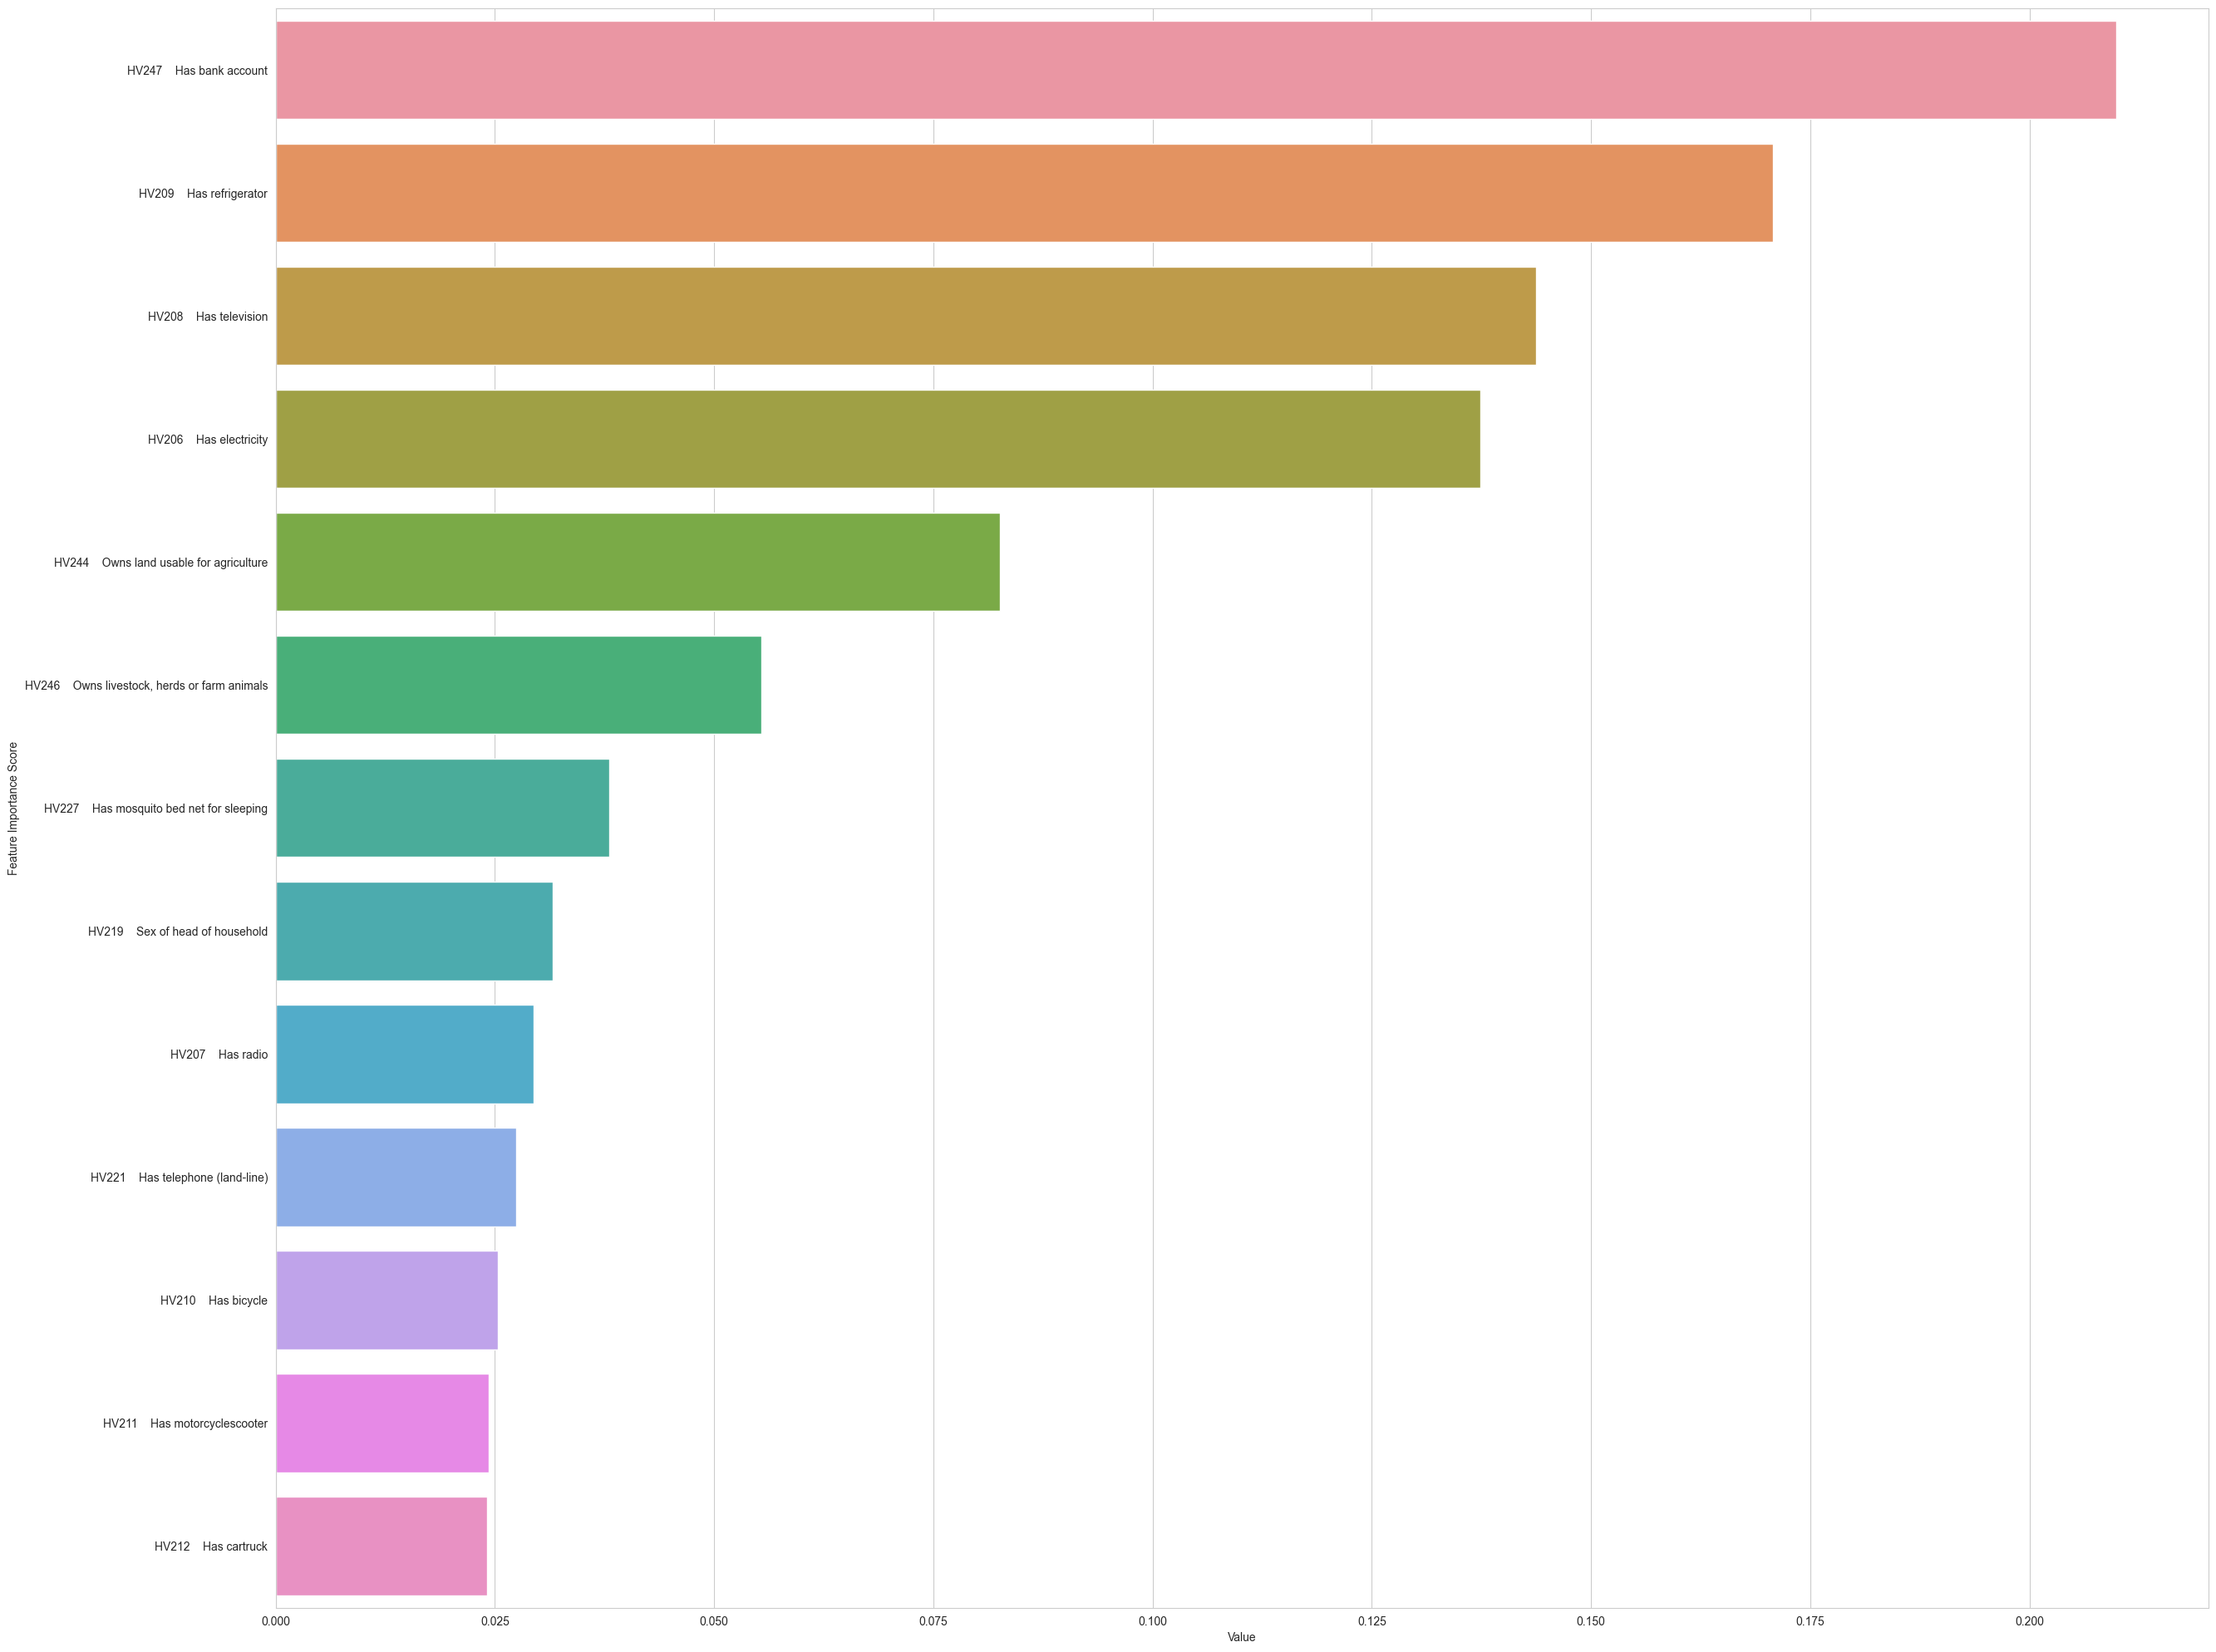

0.6827282209906366 0.6827282209906366 0.015154747680041299
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 324)               4536      
                                                                 
 dense_19 (Dense)            (None, 512)               166400    
                                                                 
 dense_20 (Dense)            (None, 1024)              525312    
                                                                 
 dense_21 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_22 (Dense)            (None, 512)               524800    
                                                                 
 dense_23 (Dense)            (None, 256)               131328    
                                                             

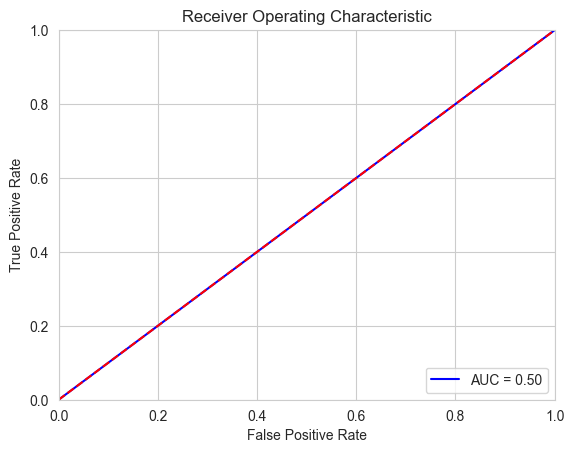

Normalized confusion matrix


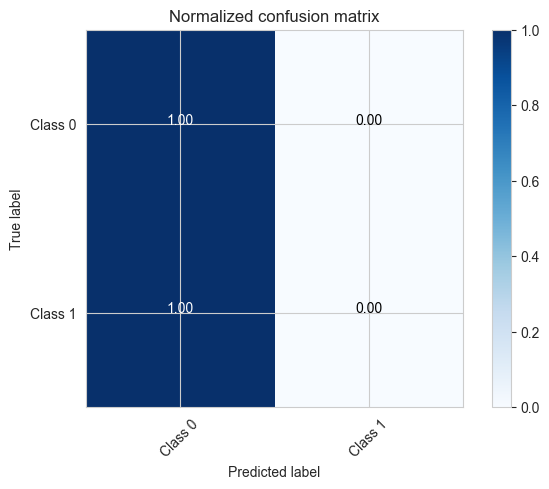

Metrics for the  Evaluation is {'accuracy': 0.7747536367902393, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Neural Network {'accuracy': 0.7747536367902393, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Classification Report
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      1651
           1       0.00      0.00      0.00       480

    accuracy                           0.77      2131
   macro avg       0.39      0.50      0.44      2131
weighted avg       0.60      0.77      0.68      2131


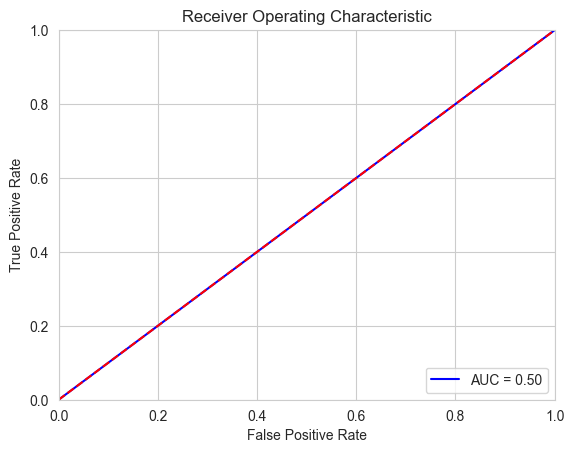

Normalized confusion matrix


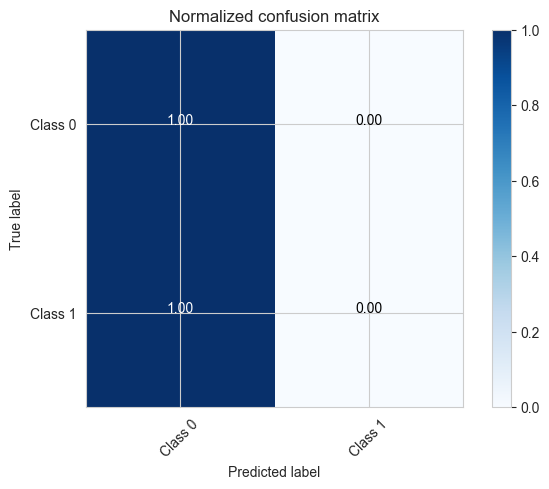

Metrics for the  Evaluation is {'accuracy': 0.7747536367902393, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Classification Report
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      1651
           1       0.00      0.00      0.00       480

    accuracy                           0.77      2131
   macro avg       0.39      0.50      0.44      2131
weighted avg       0.60      0.77      0.68      2131


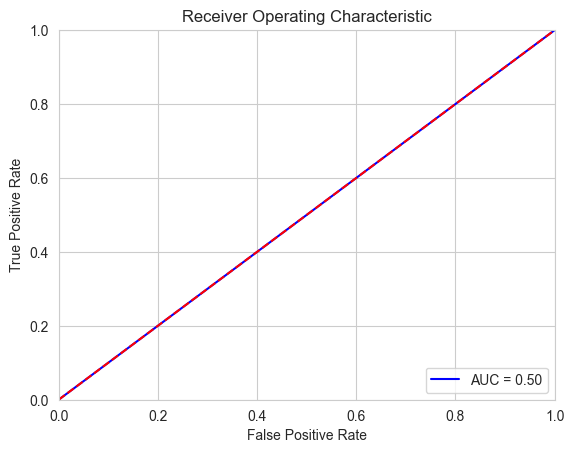

Normalized confusion matrix


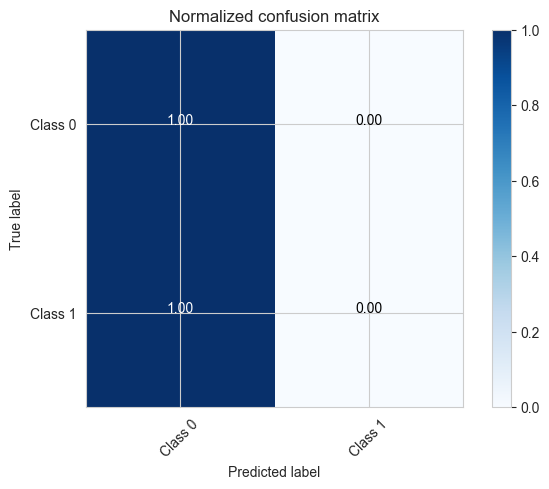

Metrics for the  Evaluation is {'accuracy': 0.7747536367902393, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Classification Report
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      1651
           1       0.00      0.00      0.00       480

    accuracy                           0.77      2131
   macro avg       0.39      0.50      0.44      2131
weighted avg       0.60      0.77      0.68      2131


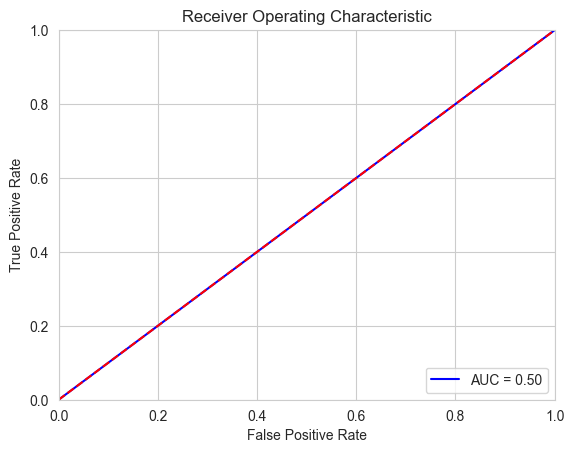

Normalized confusion matrix


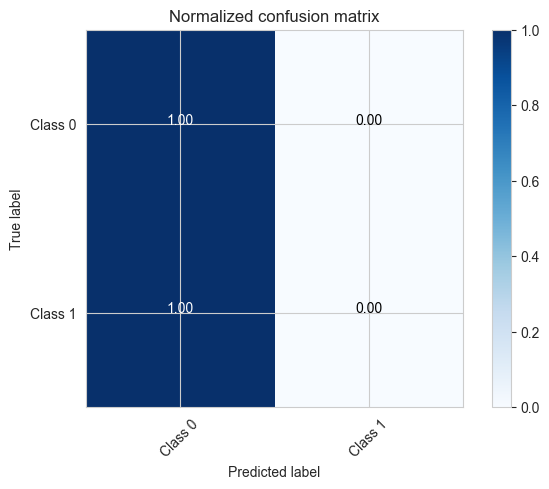

Metrics for the  Evaluation is {'accuracy': 0.7747536367902393, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
{'catboost_result': {'accuracy': 0.7747536367902393, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'xgb': {'accuracy': 0.7747536367902393, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'log': {'accuracy': 0.7747536367902393, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'neural': {'accuracy': 0.7747536367902393, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}}


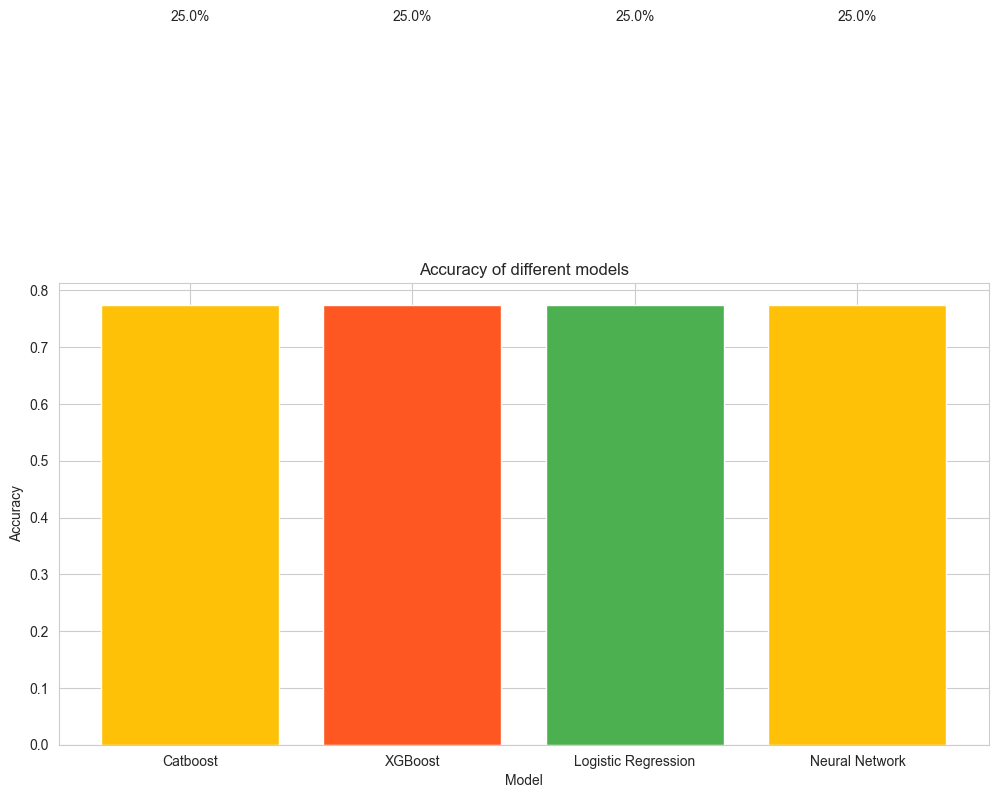

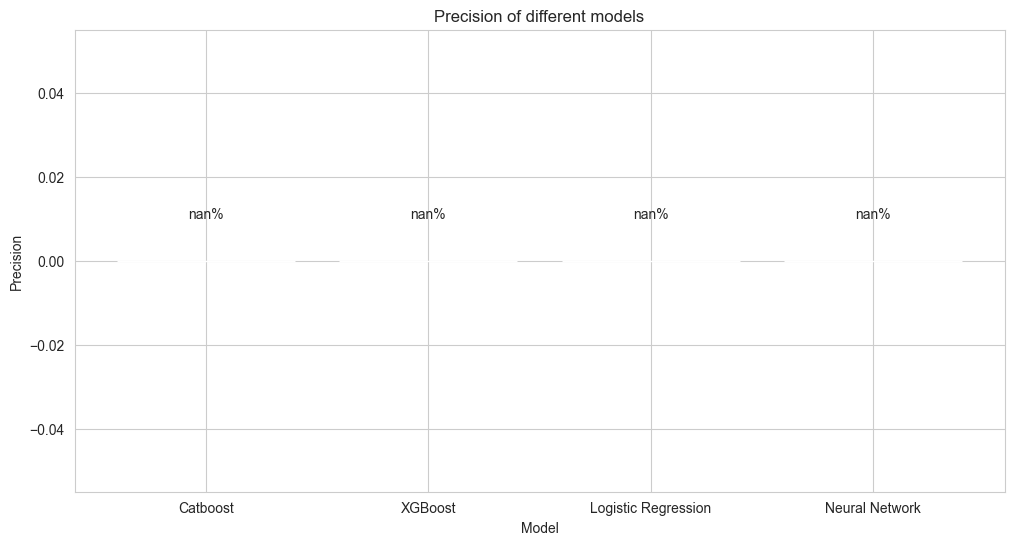

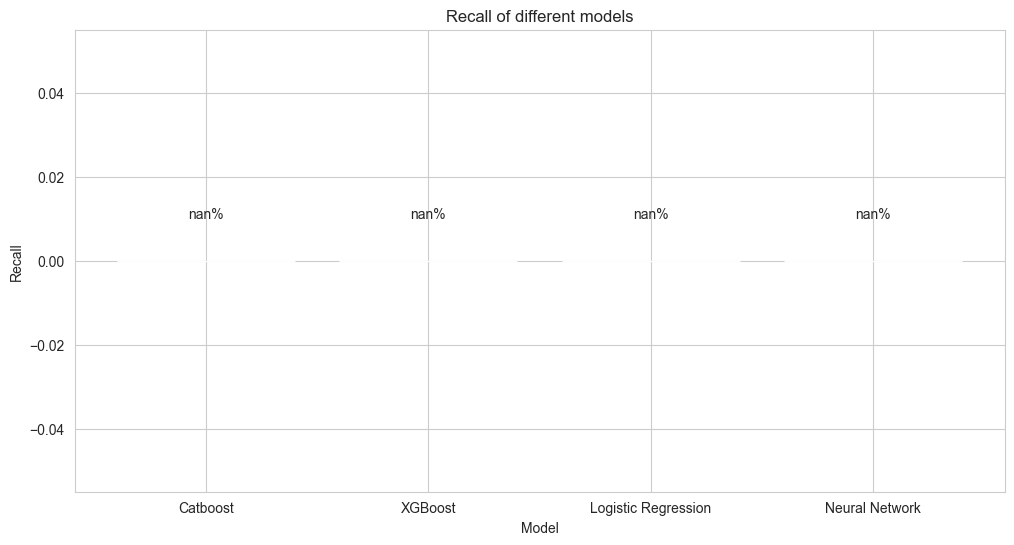

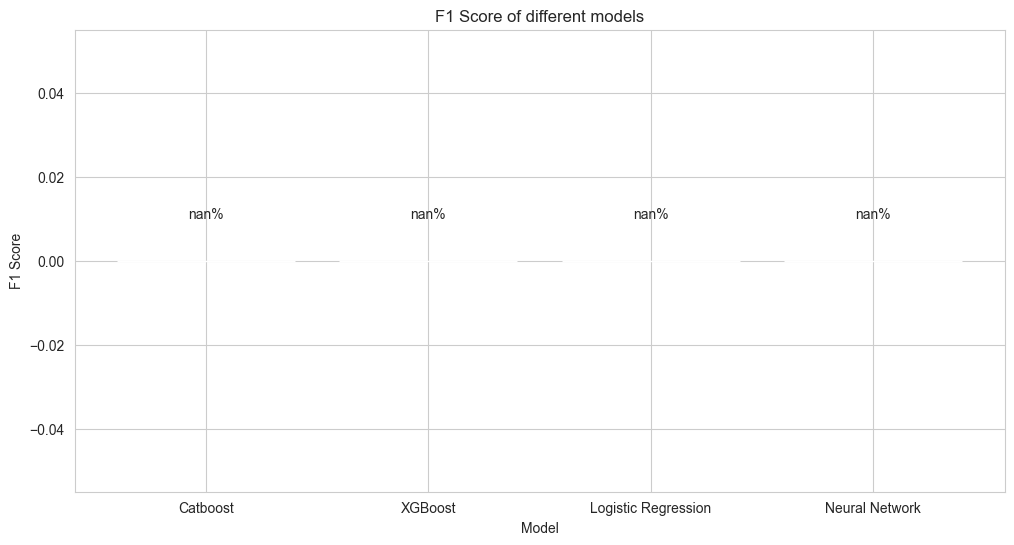

In [38]:
# Results without cross validation
X_train, X_test, y_train, y_test = train_test_split(X_data[importance], Y_data, test_size=0.2, random_state=42)
with_cross_classifier,with_cross_catboost,with_cross_xgboost, = run_predictions(X_train,y_train, X_test)
with_cross_neural_result = train_neural(X_train,y_train,X_test, y_test)
eveluate_model_results(with_cross_catboost,with_cross_xgboost, with_cross_classifier, with_cross_neural_result, y_test, X_test)

================================Fold1====================================

Validation scores 0.6692211746741948 0.6486212088547559
Training scores 0.6859425454797703 0.6384640983592473
================================Fold2====================================

Validation scores 0.6919407047867618 0.6351989168989809
Training scores 0.688302533687113 0.6345657324437006
================================Fold3====================================

Validation scores 0.6769937258087426 0.6468034773994026
Training scores 0.6787540710681026 0.6427741991272813
================================Fold4====================================

Validation scores 0.6856262872412201 0.638970026152331
Training scores 0.6856180566394394 0.639036514510834
================================Fold5====================================

Validation scores 0.6808513001099967 0.6387852437744858
Training scores 0.6785357970963832 0.6420861315634758
0.6834306007941617 0.6834306007941617 0.0040164559703927604
==================

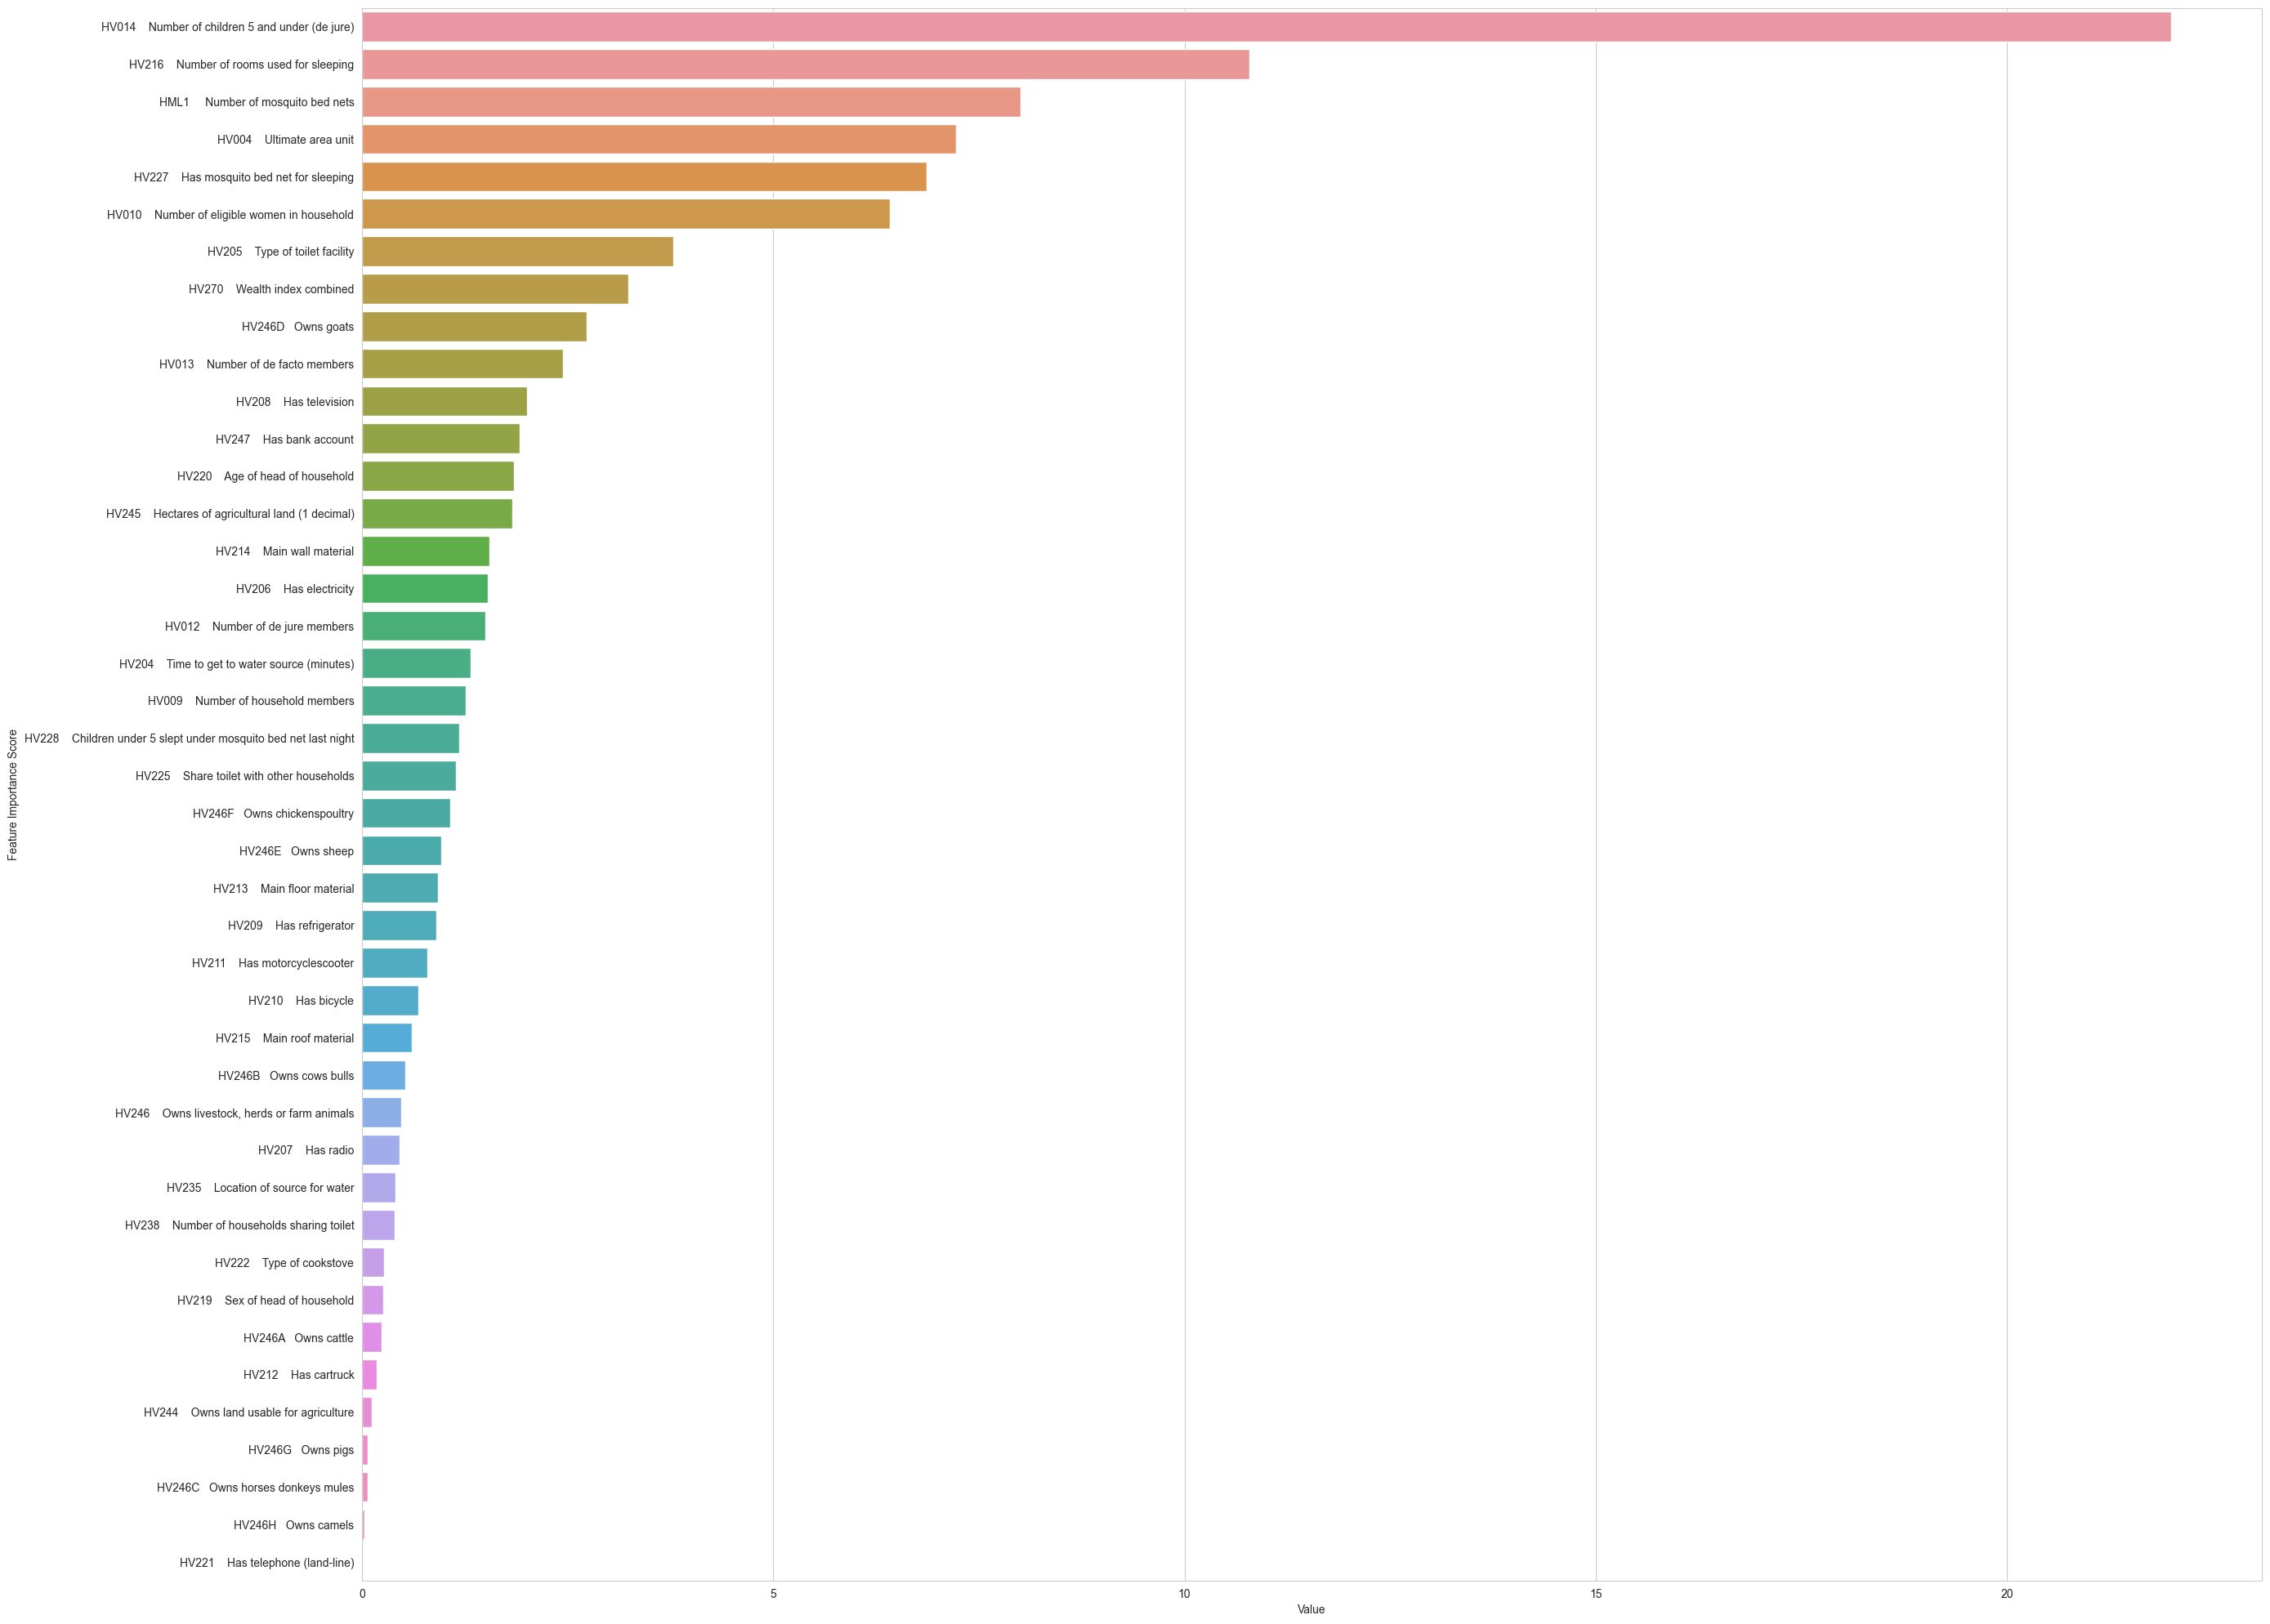

0.9682097545832548 0.9682097545832548 0.00498656344791144
================================Fold1====================================
[19:22:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "objectsve", "scoring", "sub_sample" } are not used.

[0]	validation_0-auc:0.74746
[1]	validation_0-auc:0.79197
[2]	validation_0-auc:0.81418
[3]	validation_0-auc:0.84816
[4]	validation_0-auc:0.85566
[5]	validation_0-auc:0.86335
[6]	validation_0-auc:0.86959
[7]	validation_0-auc:0.87713
[8]	validation_0-auc:0.88095
[9]	validation_0-auc:0.88225
[10]	validation_0-auc:0.88633
[11]	validation_0-auc:0.88878
[12]	validation_0-auc:0.89026
[13]	validation_0-auc:0.89176
[14]	validation_0-auc:0.89236
[15]	validation_0-auc:0.89398
[16]	validation_0-auc:0.89498
[17]	validation_0-auc:0.89540
[18]	validation_0-auc:0.89618
[19]	validation_0-auc:0.89746
[20]	validation_0-auc:0.89814
[21]	validation_0-auc:0.89969
[22]	valida

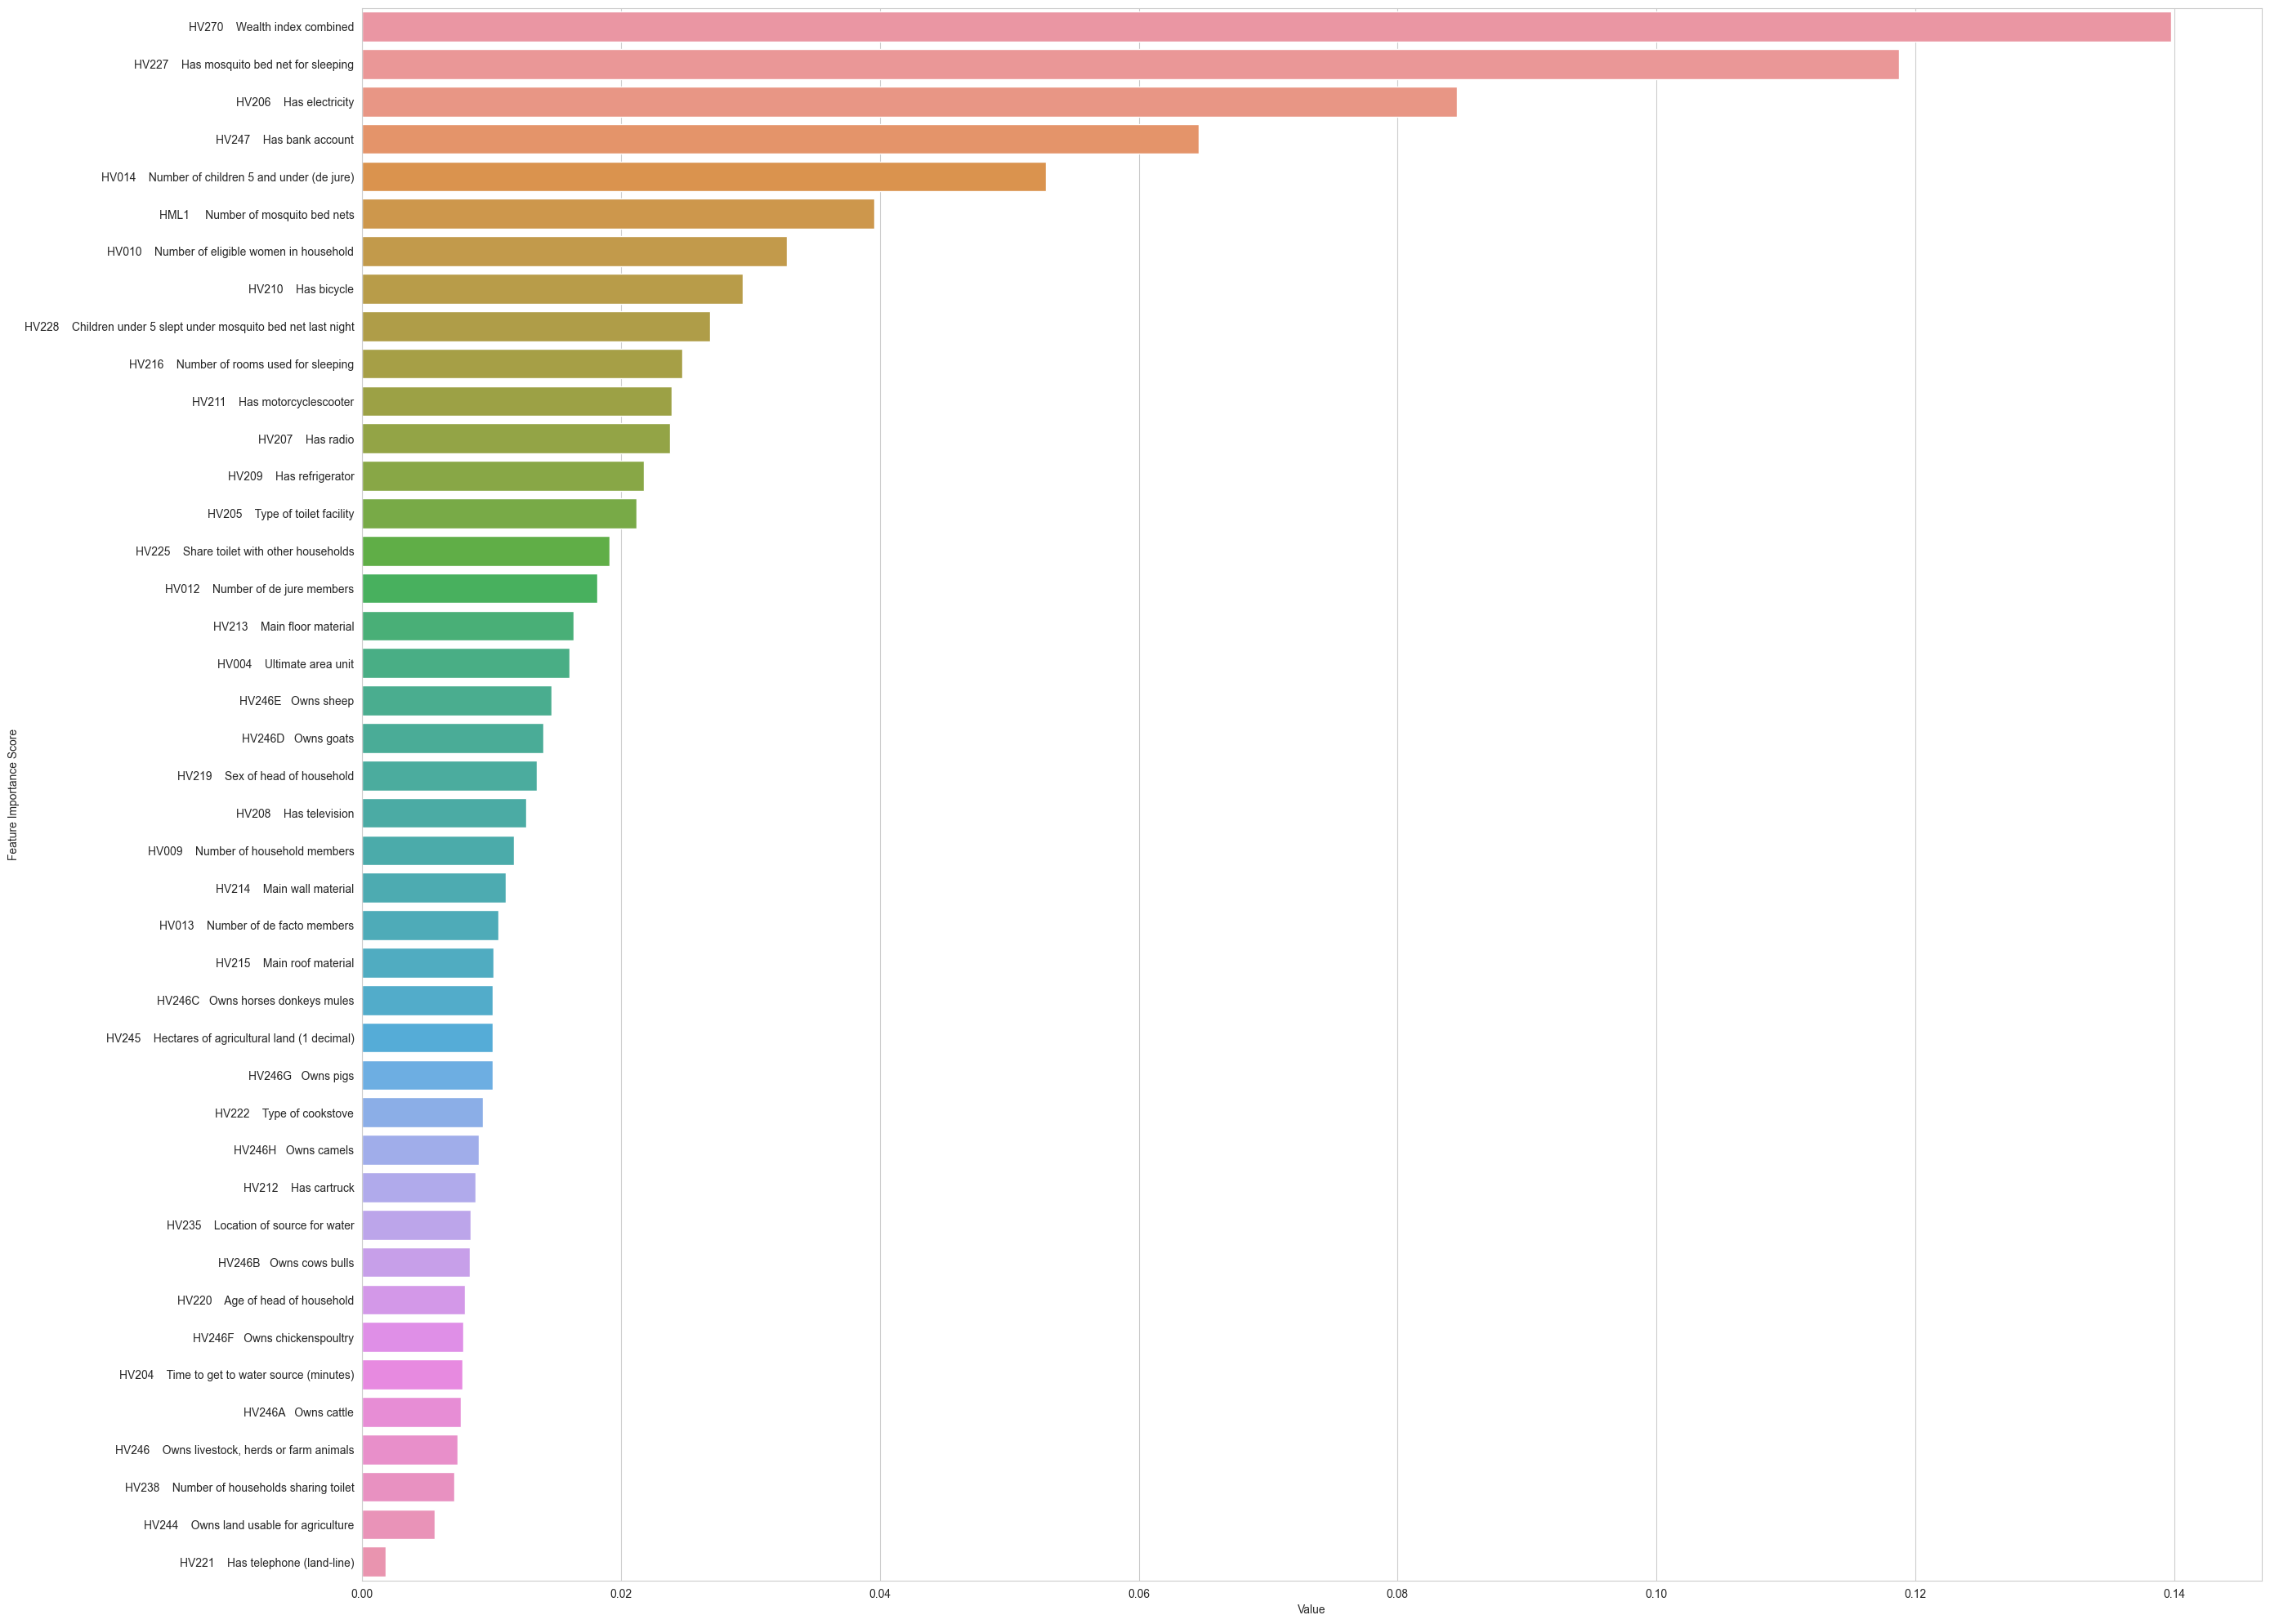

0.9862470013208675 0.9862470013208675 0.0031871855879794563
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 324)               13932     
                                                                 
 dense_28 (Dense)            (None, 512)               166400    
                                                                 
 dense_29 (Dense)            (None, 1024)              525312    
                                                                 
 dense_30 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_31 (Dense)            (None, 512)               524800    
                                                                 
 dense_32 (Dense)            (None, 256)               131328    
                                                            

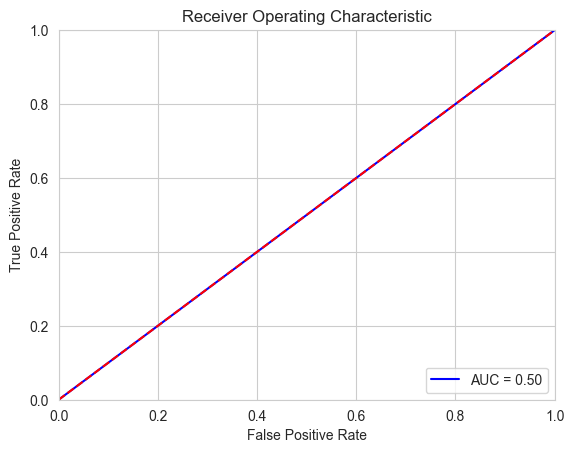

Normalized confusion matrix


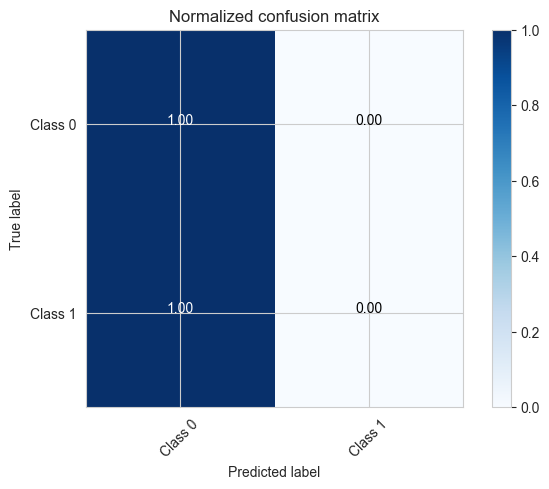

Metrics for the  Evaluation is {'accuracy': 0.5020858164481525, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Neural Network {'accuracy': 0.5020858164481525, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1685
           1       0.90      0.80      0.84      1671

    accuracy                           0.85      3356
   macro avg       0.86      0.85      0.85      3356
weighted avg       0.86      0.85      0.85      3356


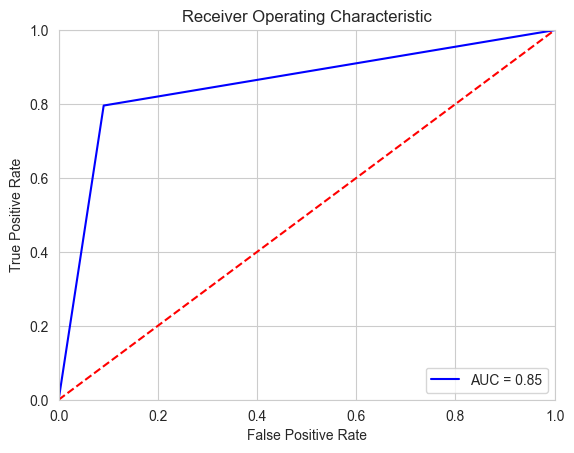

Normalized confusion matrix


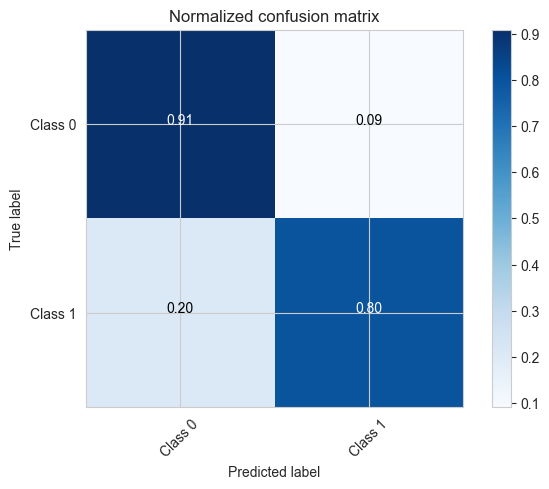

Metrics for the  Evaluation is {'accuracy': 0.8528009535160905, 'precision': 0.8968307484828051, 'recall': 0.7959305804907241, 'f1': 0.8433734939759034}
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1685
           1       0.88      0.82      0.85      1671

    accuracy                           0.86      3356
   macro avg       0.86      0.86      0.86      3356
weighted avg       0.86      0.86      0.86      3356


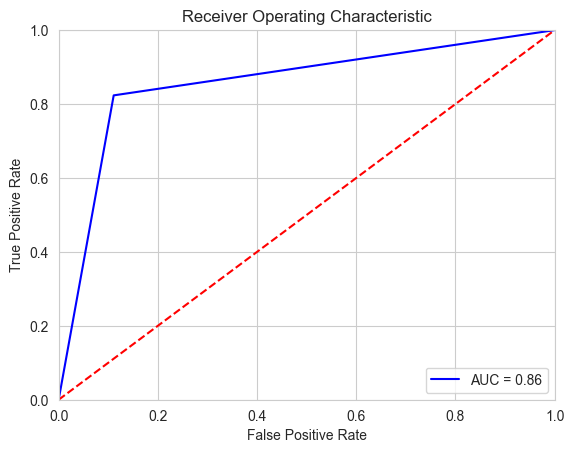

Normalized confusion matrix


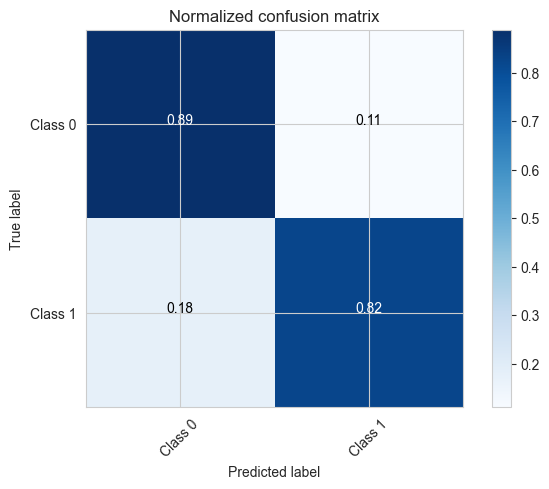

Metrics for the  Evaluation is {'accuracy': 0.8563766388557806, 'precision': 0.8803582853486884, 'recall': 0.8234590065828845, 'f1': 0.8509585652442795}
Classification Report
              precision    recall  f1-score   support

           0       0.64      0.58      0.61      1685
           1       0.62      0.68      0.64      1671

    accuracy                           0.63      3356
   macro avg       0.63      0.63      0.63      3356
weighted avg       0.63      0.63      0.63      3356


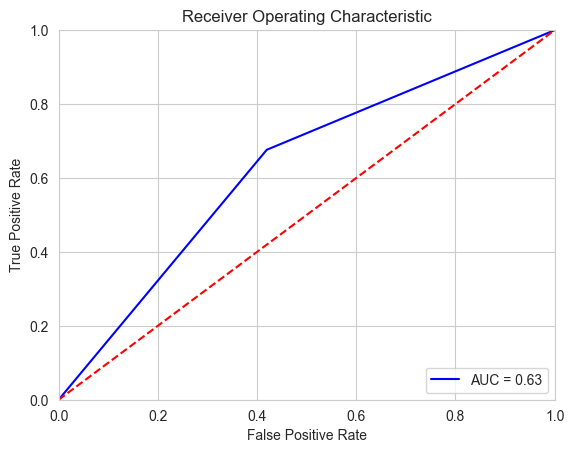

Normalized confusion matrix


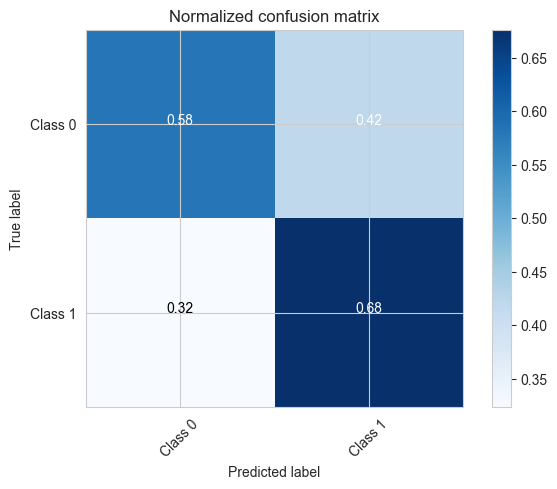

Metrics for the  Evaluation is {'accuracy': 0.6281287246722288, 'precision': 0.6151333696243876, 'recall': 0.6762417713943746, 'f1': 0.6442417331812998}
{'catboost_result': {'accuracy': 0.8528009535160905, 'precision': 0.8968307484828051, 'recall': 0.7959305804907241, 'f1': 0.8433734939759034}, 'xgb': {'accuracy': 0.8563766388557806, 'precision': 0.8803582853486884, 'recall': 0.8234590065828845, 'f1': 0.8509585652442795}, 'log': {'accuracy': 0.6281287246722288, 'precision': 0.6151333696243876, 'recall': 0.6762417713943746, 'f1': 0.6442417331812998}, 'neural': {'accuracy': 0.5020858164481525, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}}


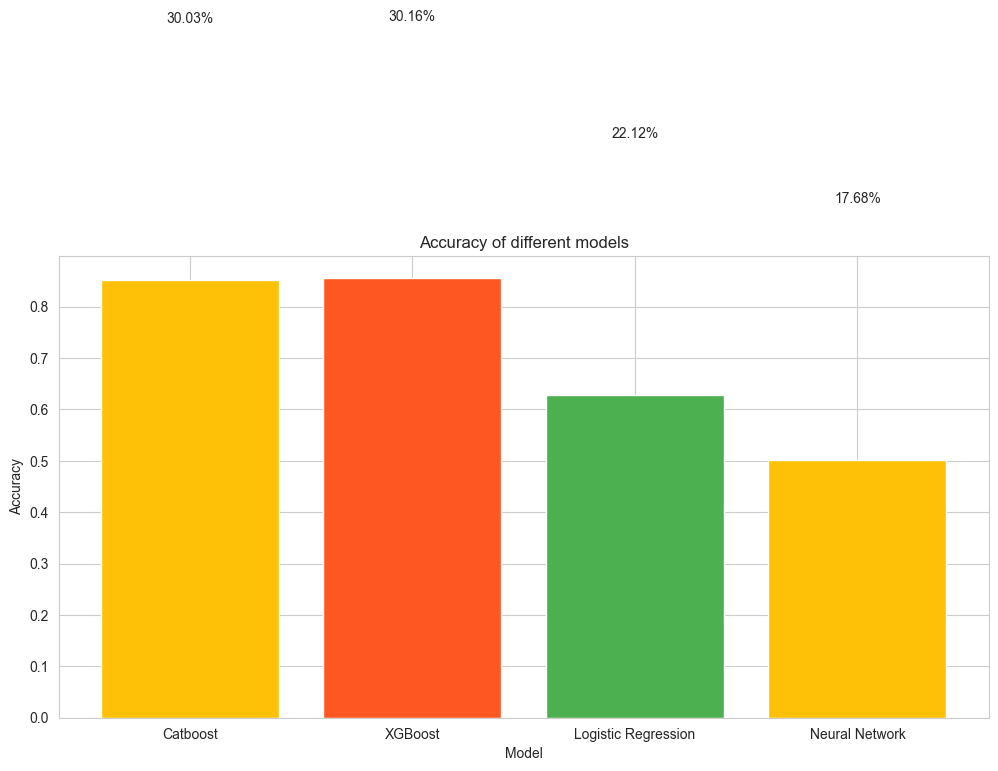

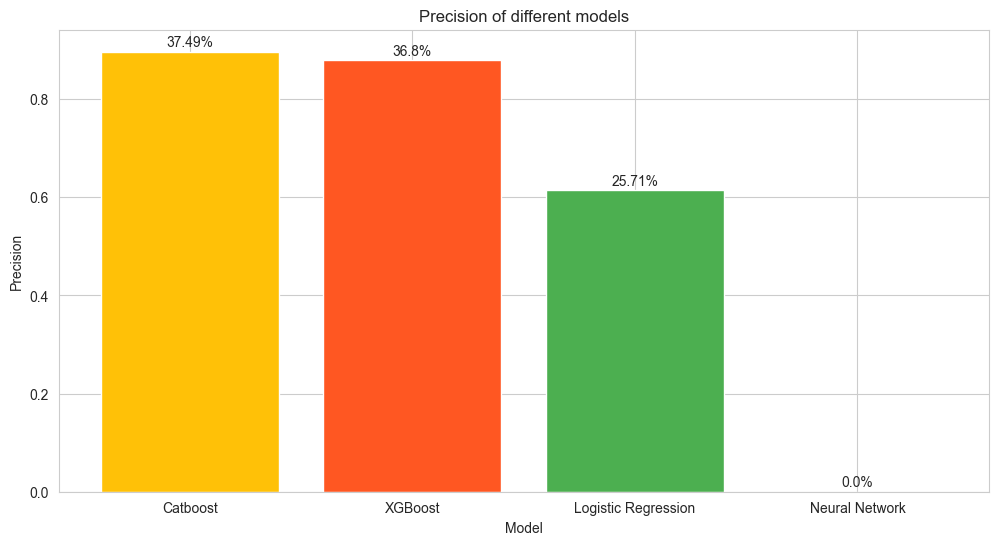

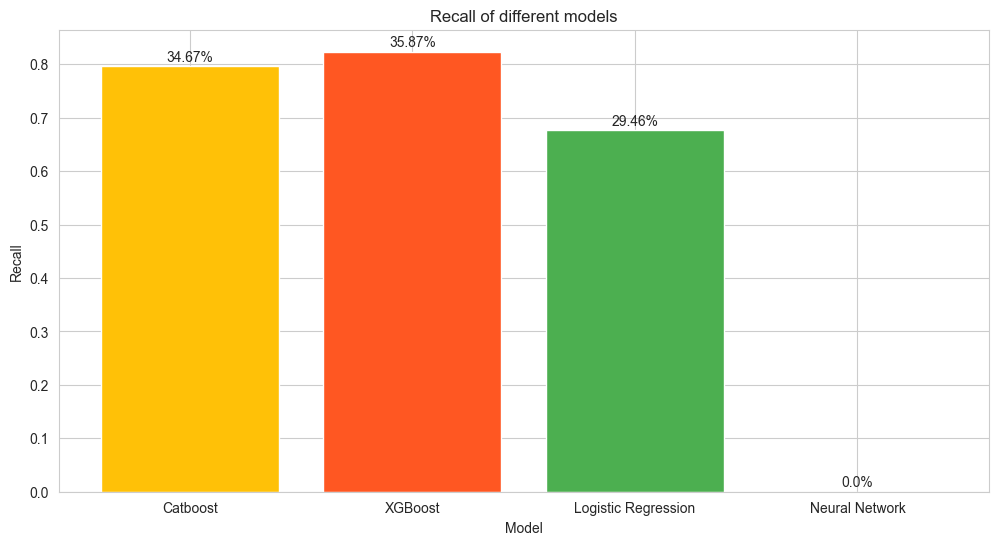

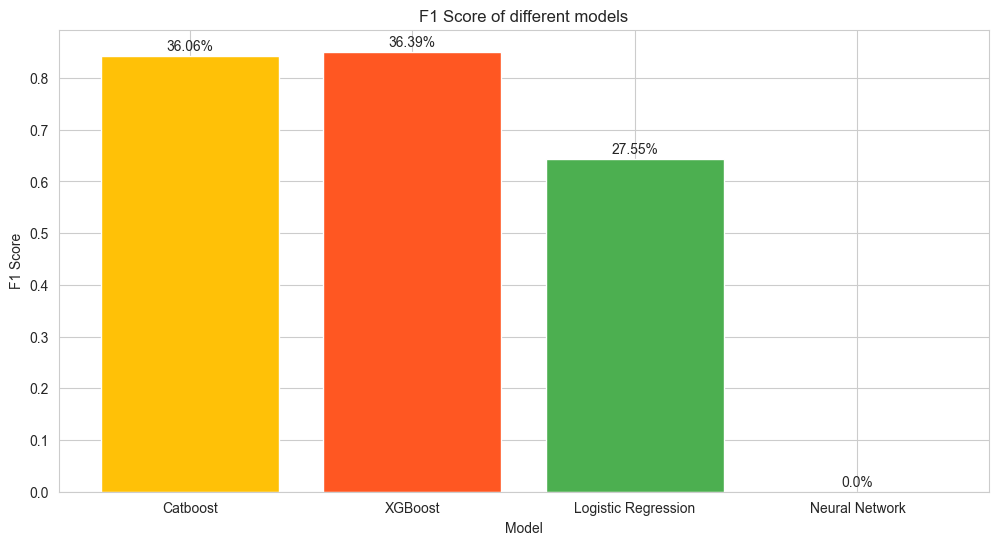

In [39]:
# Results without cross validation
_X, _Y = smote()
X_train, X_test, y_train, y_test = train_test_split(_X, _Y, test_size=0.2, random_state=42)
with_cross_classifier,with_cross_catboost,with_cross_xgboost, = run_predictions(X_train,y_train, X_test)
with_cross_neural_result = train_neural(X_train,y_train,X_test, y_test)
eveluate_model_results(with_cross_catboost,with_cross_xgboost, with_cross_classifier, with_cross_neural_result, y_test, X_test)